# Generate charts

In [ ]:
from pathlib import Path

OUTPUT_DIR = Path("./charts/")

## Figure 1 - Learning Curves

In [2]:
import copy
import csv
import math
import re
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.interpolate import interp1d

### Configuration

In [3]:
# All tasks for agregating results
ENV_TASKS = (
    "acrobot-swingup_sparse",
    "acrobot-swingup",
    "ball_in_cup-catch",
    "cartpole-balance_sparse",
    "cartpole-balance",
    "cartpole-swingup_sparse",
    "cartpole-swingup",
    "cheetah-run",
    "finger-spin",
    "finger-turn_easy",
    "finger-turn_hard",
    "fish-swim",
    "fish-upright",
    "hopper-hop",
    "hopper-stand",
    "humanoid-run",
    "humanoid-stand",
    "humanoid-walk",
    "manipulator-bring_ball",
    "pendulum-swingup",
    "point_mass-easy",
    "reacher-easy",
    "reacher-hard",
    "swimmer-swimmer15",
    "swimmer-swimmer6",
    "walker-run",
    "walker-stand",
    "walker-walk",
)

ENV_TASKS_SELECTED = (
    # "acrobot-swingup_sparse",
    # "acrobot-swingup",
    "ball_in_cup-catch",
    "cartpole-balance_sparse",
    "cartpole-balance",
    # "cartpole-swingup_sparse",
    "cartpole-swingup",
    "cheetah-run",
    "finger-spin",
    # "finger-turn_easy",
    # "finger-turn_hard",
    # "fish-swim",
    # "fish-upright",
    # "hopper-hop",
    # "hopper-stand",
    # "humanoid-run",
    # "humanoid-stand",
    # "humanoid-walk",
    # "manipulator-bring_ball",
    # "pendulum-swingup",
    "point_mass-easy",
    # "reacher-easy",
    # "reacher-hard",
    # "swimmer-swimmer15",
    # "swimmer-swimmer6",
    "walker-run",
    "walker-stand",
    "walker-walk",
)

ENV_TASKS_DISCARTED = (
    "acrobot-swingup_sparse",
    "acrobot-swingup",
    # "ball_in_cup-catch",
    # "cartpole-balance_sparse",
    # "cartpole-balance",
    "cartpole-swingup_sparse",
    # "cartpole-swingup",
    # "cheetah-run",
    # "finger-spin",
    "finger-turn_easy",
    "finger-turn_hard",
    "fish-swim",
    "fish-upright",
    "hopper-hop",
    "hopper-stand",
    "humanoid-run",
    "humanoid-stand",
    "humanoid-walk",
    "manipulator-bring_ball",
    "pendulum-swingup",
    # "point_mass-easy",
    "reacher-easy",
    "reacher-hard",
    "swimmer-swimmer15",
    "swimmer-swimmer6",
    # "walker-run",
    # "walker-stand",
    # "walker-walk",
)

### Loading data

In [4]:
# Construct data to plot

results_path = Path("/mnt/ws/eval_workdir_results")
LEARNING_RESULTS = None

LIST_OF_PROGRESS_VARIABLES = (
    "num_env_steps_sampled",
    "episode_reward_max",
    "episode_reward_min",
    "episode_reward_mean",
)
DATA_KEYS = {
    "steps": LIST_OF_PROGRESS_VARIABLES[0],
    "reward_max": LIST_OF_PROGRESS_VARIABLES[1],
    "reward_min": LIST_OF_PROGRESS_VARIABLES[2],
    "reward_mean": LIST_OF_PROGRESS_VARIABLES[3],
}

NUMBER_OF_MODELS = 5
NUMBER_OF_ENV_TASKS = 28
NUMBER_OF_ALGOS = 3


def load_training_progress(path: Path) -> Dict[str, Dict]:
    def get_task_env_name(directory_name: str) -> str:
        pattern = ".+?_(.+?)_[0-9,-]+_.+"
        return re.findall(pattern, directory.name)[0]

    def get_algos_dirs(results_path: Path) -> List[str]:
        return [
            x.name for x in results_path.iterdir() if x.name in ["SAC", "PPO", "DDPG"]
        ]

    results = {}
    for algo in get_algos_dirs(results_path):
        results[algo] = {}
        working_path = path.joinpath(algo)

        for directory in working_path.iterdir():
            env = get_task_env_name(directory.name)

            if results[algo].get(env, None) is None:
                results[algo][env] = {}

            progress = {k: [] for k in LIST_OF_PROGRESS_VARIABLES}
            try:
                with working_path.joinpath(directory, "progress.csv").open(
                    "r"
                ) as csv_file:
                    csv_reader = csv.DictReader(csv_file)
                    for row in csv_reader:
                        for var in LIST_OF_PROGRESS_VARIABLES:
                            progress[var].append(row[var])
            except FileNotFoundError as e:
                print(
                    f"ERROR: Couldn't find progress.csv file. Leaving an empty dict! | Exception: {e}"
                )

            model_idx = len(results[algo][env])
            results[algo][env][model_idx] = progress
    return results


LEARNING_RESULTS = load_training_progress(results_path)

In [5]:
def assert_print(val1, val2, text: str) -> None:
    def bool2ok(x: bool) -> str:
        return " OK " if x else "NOK "

    ok = bool2ok(val1 == val2)
    print(f"[{ok}] {text}: {val1}/{val2}")


print(f">>> CHECKING INTEGRITY OF LOADED LEARNING RESULTS:")

assert_print(len(LEARNING_RESULTS), NUMBER_OF_ALGOS, ">> REGISTERED ALGORITHMS")
print("################################################################")
for k, v in LEARNING_RESULTS.items():
    assert_print(len(v), NUMBER_OF_ENV_TASKS, f">> [{k}] env-tasks")
    for env_task, models in v.items():
        assert_print(len(models), NUMBER_OF_MODELS, f"> {env_task} contains models")
        for idx, progress_vals in models.items():
            assert idx in range(
                len(models)
            ), f"Something is wrong with model indexing: {idx}"
            for var_name in progress_vals.keys():
                assert (
                    var_name in LIST_OF_PROGRESS_VARIABLES
                ), f"An extra type of value has been dected: {var_name}"
    print("################################################################")

>>> CHECKING INTEGRITY OF LOADED LEARNING RESULTS:
[ OK ] >> REGISTERED ALGORITHMS: 3/3
################################################################
[ OK ] >> [DDPG] env-tasks: 28/28
[ OK ] > humanoid-run contains models: 5/5
[ OK ] > reacher-hard contains models: 5/5
[ OK ] > ball_in_cup-catch contains models: 5/5
[ OK ] > humanoid-stand contains models: 5/5
[ OK ] > finger-turn_hard contains models: 5/5
[ OK ] > acrobot-swingup_sparse contains models: 5/5
[ OK ] > humanoid-walk contains models: 5/5
[ OK ] > cartpole-swingup contains models: 5/5
[ OK ] > cartpole-balance_sparse contains models: 5/5
[ OK ] > cartpole-balance contains models: 5/5
[ OK ] > swimmer-swimmer6 contains models: 5/5
[ OK ] > finger-turn_easy contains models: 5/5
[ OK ] > point_mass-easy contains models: 5/5
[ OK ] > walker-run contains models: 5/5
[ OK ] > manipulator-bring_ball contains models: 5/5
[ OK ] > walker-walk contains models: 5/5
[ OK ] > fish-swim contains models: 5/5
[ OK ] > acrobot-swingup c

### Utils & preprocessing

In [6]:
def generate_scale(x: int, length: int) -> np.array:
    min_val = int(2e3)
    return np.arange(min_val, x + 1, (x - min_val) / length)


def downsample_data(data_x: List, data_y: List, steps_scale: List) -> List:
    interpolator = interp1d(data_x, data_y, kind="linear")
    return interpolator(steps_scale)


def is_arrays_len_equal(a: np.array, b: np.array) -> bool:
    return len(a) == len(b)


def raw_data_to_array(x: List, astype: str = "float", nan: float = 0.0) -> np.array:
    result = np.array(x).astype(astype)
    return np.nan_to_num(result, nan=nan)

In [8]:
DATA_TO_PLOT = {}
FALLBACK_NO_OF_POINTS = 500
STEPS_HORIZION = int(5e5)


def sac_preprocessing(
    models: Dict[int, Dict[str, List[float]]]
) -> Dict[int, Dict[str, List[float]]]:
    # Function to align timeseries of SAC models

    steps_scale = generate_scale(STEPS_HORIZION, FALLBACK_NO_OF_POINTS)
    downsampled_models = {k: {} for k in models.keys()}

    for model_idx, progress_data in models.items():
        raw_steps = [int(x) for x in progress_data[DATA_KEYS["steps"]]]
        reward_min = [float(x) for x in progress_data[DATA_KEYS["reward_min"]]]
        reward_max = [float(x) for x in progress_data[DATA_KEYS["reward_max"]]]
        reward_mean = [float(x) for x in progress_data[DATA_KEYS["reward_mean"]]]

        downsampled_models[model_idx] = {
            DATA_KEYS["steps"]: steps_scale,
            DATA_KEYS["reward_min"]: downsample_data(
                raw_steps, reward_min, steps_scale
            ),
            DATA_KEYS["reward_max"]: downsample_data(
                raw_steps, reward_max, steps_scale
            ),
            DATA_KEYS["reward_mean"]: downsample_data(
                raw_steps, reward_mean, steps_scale
            ),
        }

    return downsampled_models


for algo, env_tasks in LEARNING_RESULTS.items():
    DATA_TO_PLOT[algo] = {}
    for env_task, models in env_tasks.items():
        DATA_TO_PLOT[algo][env_task] = {}
        data = {k: None for k in LIST_OF_PROGRESS_VARIABLES}

        if algo == "SAC":
            models = sac_preprocessing(models)

        for model, progress in models.items():
            for var_name, var_list in progress.items():
                var_array = np.array(var_list).astype(float)
                if var_name == DATA_KEYS["steps"]:
                    data[var_name] = var_array
                    continue

                try:
                    divided_value = var_array / len(models)
                    if data[var_name] is not None:
                        data[var_name] += divided_value
                    else:
                        data[var_name] = divided_value
                except ValueError as e:
                    print(
                        f"ERROR: Length missmatch for [{algo}][{env_task}][{model}][{var_name}]:  data[{var_name}] is {len(data[var_name])}; divided_value is {len(divided_value)}"
                    )

                data[var_name] = np.nan_to_num(data[var_name], nan=0)
        DATA_TO_PLOT[algo][env_task] = copy.copy(data)

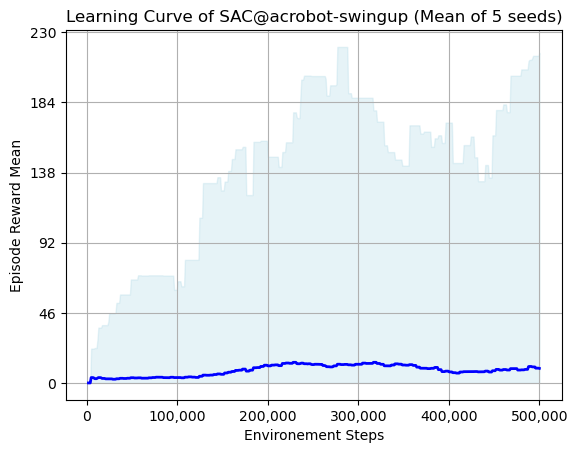

In [9]:
algo = "SAC"
env_task = "acrobot-swingup"

x = DATA_TO_PLOT[algo][env_task]["num_env_steps_sampled"]
y = DATA_TO_PLOT[algo][env_task]["episode_reward_mean"]
y_min = DATA_TO_PLOT[algo][env_task]["episode_reward_min"]
y_max = DATA_TO_PLOT[algo][env_task]["episode_reward_max"]

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y, color="blue", linewidth=2)
plt.fill_between(x, y_min, y_max, color="lightblue", alpha=0.3)

# Set the x-axis major tick locations and labels
x_major_ticks = np.linspace(0, round(x[-1], -2), 6)  # Specify the major tick positions
ax.set_xticks(x_major_ticks)
ax.set_xticklabels(
    [f"{int(tick):,}" for tick in x_major_ticks]
)  # Format labels as thousands separated with commas

# Set the y-axis major tick locations and labels
y_max_rounded = np.ceil(np.max(y_max) / 10) * 10
y_major_ticks = np.linspace(0, y_max_rounded, 6)  # Specify the major tick positions
ax.set_yticks(y_major_ticks)
ax.set_yticklabels(
    [f"{int(tick):,}" for tick in y_major_ticks]
)  # Format labels as thousands separated with commas

# Add labels and title
ax.set_xlabel("Environement Steps")
ax.set_ylabel("Episode Reward Mean")
ax.set_title(f"Learning Curve of {algo}@{env_task} (Mean of 5 seeds)")

# Display the plot
plt.grid(True)
plt.show()

[  0.           0.           0.         ... 298.16881899 298.16881899
 301.25086439]
Types: x:<class 'numpy.float64'> y:<class 'numpy.float64'> y_min:<class 'numpy.float64'> y_max:<class 'numpy.float64'>
Length: x:3794 y:3794 y_min:3794 y_max:3794


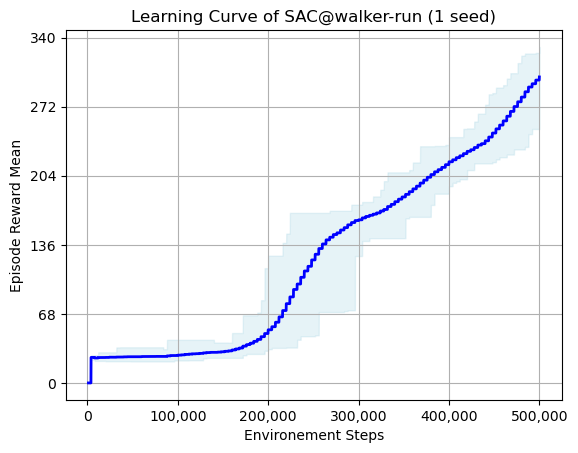

In [10]:
algo = "SAC"
env_task = "walker-run"

idx = 2
x = np.nan_to_num(
    np.array(LEARNING_RESULTS[algo][env_task][idx]["num_env_steps_sampled"]).astype(
        float
    ),
    nan=0,
)
y = np.nan_to_num(
    np.array(LEARNING_RESULTS[algo][env_task][idx]["episode_reward_mean"]).astype(
        float
    ),
    nan=0,
)
y_min = np.nan_to_num(
    np.array(LEARNING_RESULTS[algo][env_task][idx]["episode_reward_min"]).astype(float),
    nan=0,
)
y_max = np.nan_to_num(
    np.array(LEARNING_RESULTS[algo][env_task][idx]["episode_reward_max"]).astype(float),
    nan=0,
)

print(y)

print(
    f"Types: x:{type(x[0])} y:{type(y[0])} y_min:{type(y_min[0])} y_max:{type(y_max[0])}"
)
print(f"Length: x:{len(x)} y:{len(y)} y_min:{len(y_min)} y_max:{len(y_max)}")

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y, color="blue", linewidth=2)
plt.fill_between(x, y_min, y_max, color="lightblue", alpha=0.3)

# Set the x-axis major tick locations and labels
x_major_ticks = np.linspace(0, round(x[-1], -2), 6)  # Specify the major tick positions
ax.set_xticks(x_major_ticks)
ax.set_xticklabels(
    [f"{int(tick):,}" for tick in x_major_ticks]
)  # Format labels as thousands separated with commas

# Set the y-axis major tick locations and labels
y_max_rounded = np.ceil(np.max(y_max) / 10) * 10
y_major_ticks = np.linspace(0, y_max_rounded, 6)  # Specify the major tick positions
ax.set_yticks(y_major_ticks)
ax.set_yticklabels(
    [f"{int(tick):,}" for tick in y_major_ticks]
)  # Format labels as thousands separated with commas

# Add labels and title
ax.set_xlabel("Environement Steps")
ax.set_ylabel("Episode Reward Mean")
# ax.set_title(f'Learning Curve of {algo}@{env_task} (Mean of 5 seeds)')
ax.set_title(f"Learning Curve of {algo}@{env_task} (1 seed)")

# Display the plot
plt.grid(True)
plt.show()

### Selected Task-Envs

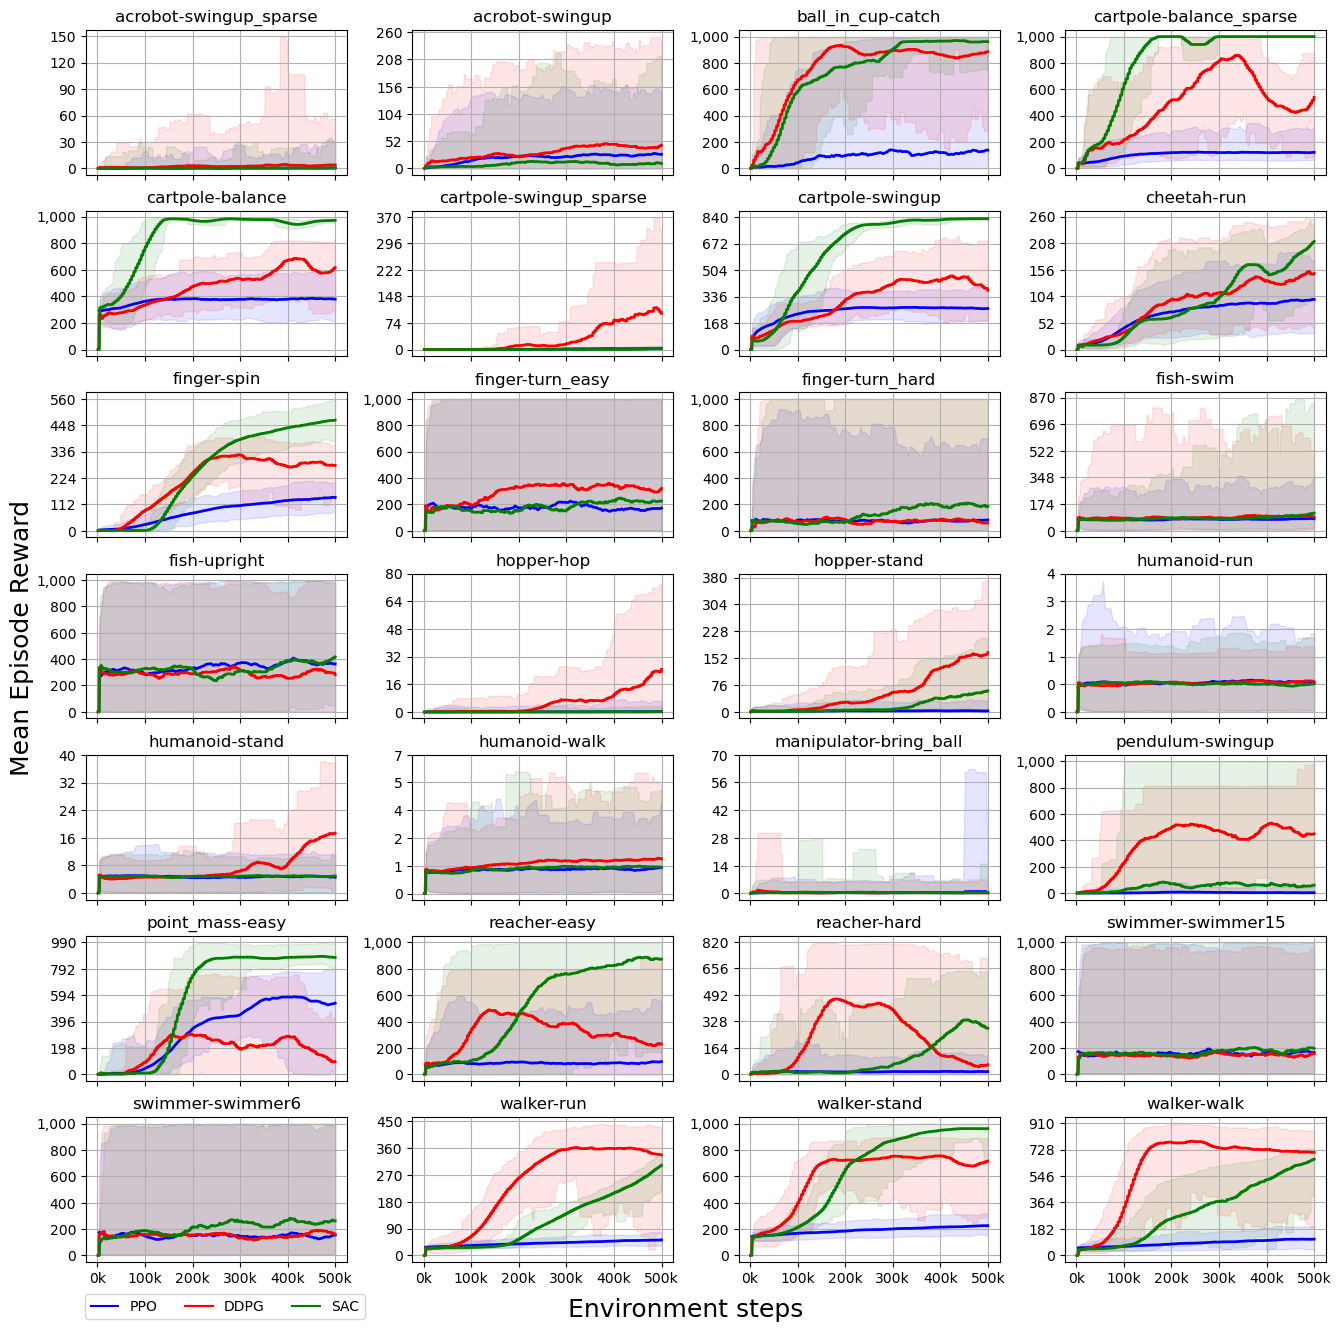

In [11]:
# Create a figure with 2 rows and 14 columns
FIG_NAME = "learning_curves_aggregated"
FIG_ROWS = 7
FIG_COLS = 4
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=(16, 16))


def plot_data(
    algo: str, env_task: str, ax, data_to_plot, color: str, prev_max_value: float
) -> float:
    x = DATA_TO_PLOT[algo][env_task]["num_env_steps_sampled"]
    y = DATA_TO_PLOT[algo][env_task]["episode_reward_mean"]
    y_min = DATA_TO_PLOT[algo][env_task]["episode_reward_min"]
    y_max = DATA_TO_PLOT[algo][env_task]["episode_reward_max"]

    # Plot the data
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, y_min, y_max, color=color, alpha=0.1)

    # Set the x-axis major tick locations and labels
    x_major_ticks = np.linspace(
        0, round(x[-1], -2), 6
    )  # Specify the major tick positions
    ax.set_xticks(x_major_ticks)
    ax.set_xticklabels(
        [f"{int(tick * 1e-3):.0f}k" for tick in x_major_ticks]
    )  # Format labels as thousands separated with commas

    # Set the y-axis major tick locations and labels
    if np.max(y_max) > 10:
        y_max_rounded = np.ceil(np.max(y_max) / 10) * 10
    else:
        y_max_rounded = np.ceil(np.max(y_max))
    y_max_rounded = y_max_rounded if y_max_rounded > prev_max_value else prev_max_value
    y_major_ticks = np.linspace(0, y_max_rounded, 6)  # Specify the major tick positions
    ax.set_yticks(y_major_ticks)
    ax.set_yticklabels(
        [f"{int(tick):,}" for tick in y_major_ticks]
    )  # Format labels as thousands separated with commas

    return y_max_rounded


# Iterate over the axes and plot something on each of them
for i in range(FIG_ROWS):
    for j in range(FIG_COLS):
        idx = i * FIG_COLS + j
        if idx >= len(ENV_TASKS):
            continue
        env_task = ENV_TASKS[idx]
        ax = axes[i][j]

        try:
            max_val = 0.0
            for algo, color in ALGOS.items():
                max_val = plot_data(algo, env_task, ax, DATA_TO_PLOT, color, max_val)
        except ValueError as e:
            print(f"For {algo}@{env_task} an execption occured")
            raise e
        ax.set_title(env_task)

        # Add grid lines to the subplot
        ax.grid(True)

        # Turn off x-axis labels for all rows except the last one
        if i < FIG_ROWS - 1:
            ax.tick_params(labelbottom=False)

# Add a common ylabel for all rows
fig.text(
    0.085,
    0.5,
    "Mean Episode Reward",
    fontsize=18,
    ha="center",
    va="center",
    rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Add a common xlabel for all collumns
fig.text(
    0.5,
    0.08,
    "Environment steps",
    fontsize=18,
    ha="center",
    va="center",
    # rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Increase the horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Add a legend below the subplots
handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]
fig.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="lower left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0.12, 0.07),
)

result_file = OUTPUT_DIR.joinpath(f"{FIG_NAME}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

### Discarded Task-Envs

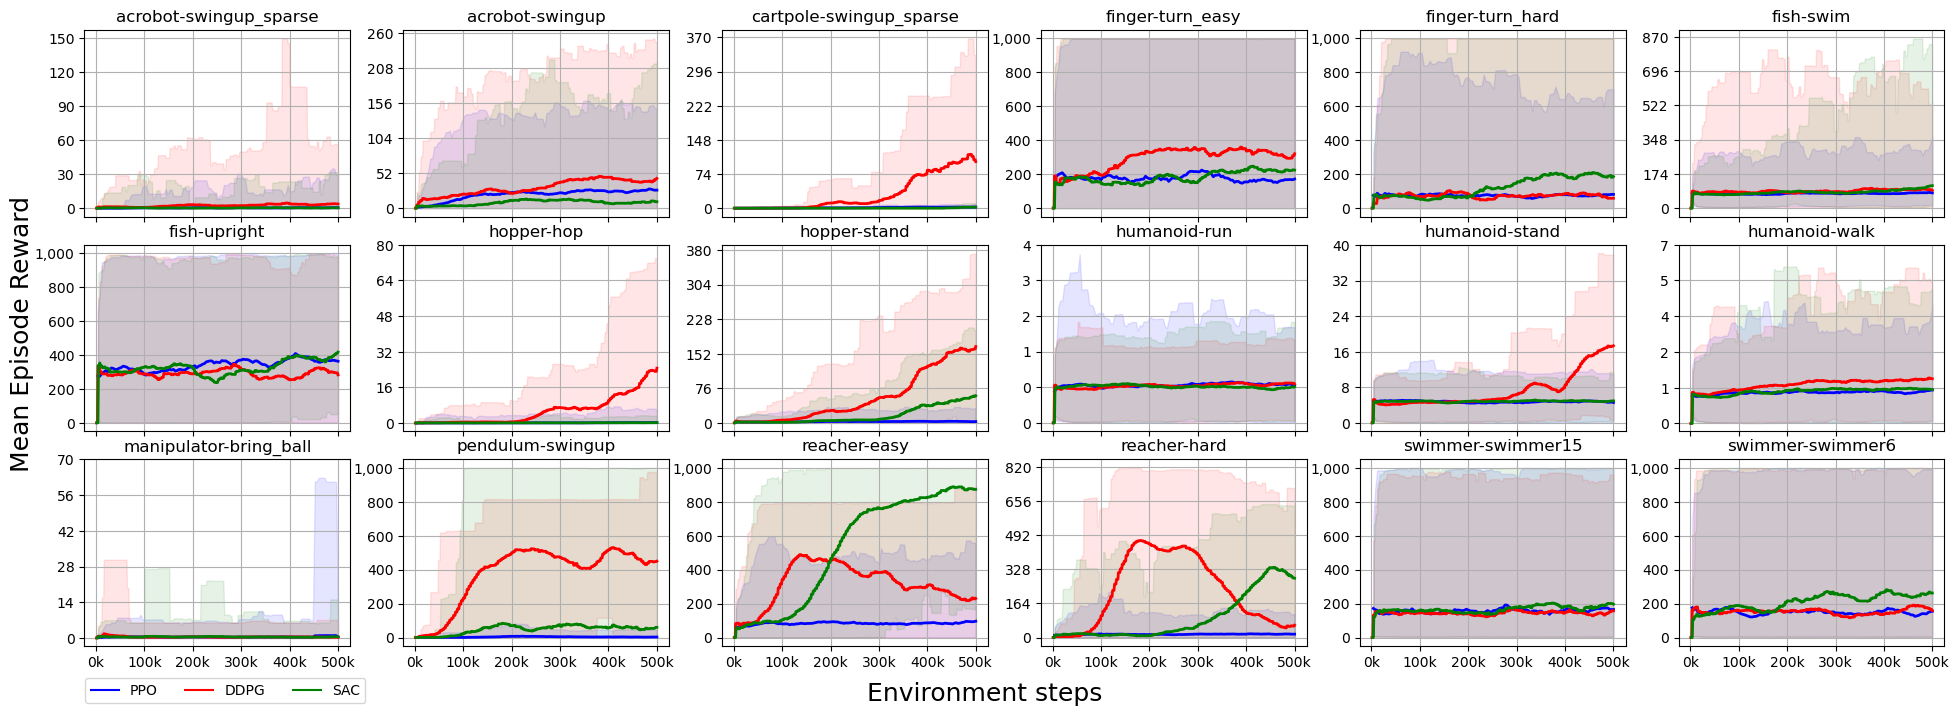

In [12]:
FIG_NAME = "learning_curves_discarted"
FIG_ROWS = 3
FIG_COLS = 6
FIG_SIZE = (24, 8)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=FIG_SIZE)


def plot_data(
    algo: str, env_task: str, ax, data_to_plot, color: str, prev_max_value: float
) -> float:
    x = DATA_TO_PLOT[algo][env_task]["num_env_steps_sampled"]
    y = DATA_TO_PLOT[algo][env_task]["episode_reward_mean"]
    y_min = DATA_TO_PLOT[algo][env_task]["episode_reward_min"]
    y_max = DATA_TO_PLOT[algo][env_task]["episode_reward_max"]

    # Plot the data
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, y_min, y_max, color=color, alpha=0.1)

    # Set the x-axis major tick locations and labels
    x_major_ticks = np.linspace(
        0, round(x[-1], -2), 6
    )  # Specify the major tick positions
    ax.set_xticks(x_major_ticks)
    ax.set_xticklabels(
        [f"{int(tick * 1e-3):.0f}k" for tick in x_major_ticks]
    )  # Format labels as thousands separated with commas

    # Set the y-axis major tick locations and labels
    if np.max(y_max) > 10:
        y_max_rounded = np.ceil(np.max(y_max) / 10) * 10
    else:
        y_max_rounded = np.ceil(np.max(y_max))
    y_max_rounded = y_max_rounded if y_max_rounded > prev_max_value else prev_max_value
    y_major_ticks = np.linspace(0, y_max_rounded, 6)  # Specify the major tick positions
    ax.set_yticks(y_major_ticks)
    ax.set_yticklabels(
        [f"{int(tick):,}" for tick in y_major_ticks]
    )  # Format labels as thousands separated with commas

    return y_max_rounded


# Iterate over the axes and plot something on each of them
for i in range(FIG_ROWS):
    for j in range(FIG_COLS):
        idx = i * FIG_COLS + j
        if idx >= len(ENV_TASKS_DISCARTED):
            continue
        env_task = ENV_TASKS_DISCARTED[idx]
        ax = axes[i][j]

        try:
            max_val = 0.0
            for algo, color in ALGOS.items():
                max_val = plot_data(algo, env_task, ax, DATA_TO_PLOT, color, max_val)
        except ValueError as e:
            print(f"For {algo}@{env_task} an execption occured")
            raise e
        ax.set_title(env_task)

        # Add grid lines to the subplot
        ax.grid(True)

        # Turn off x-axis labels for all rows except the last one
        if i < FIG_ROWS - 1:
            ax.tick_params(labelbottom=False)

# Add a common ylabel for all rows
fig.text(
    0.099,
    0.5,
    "Mean Episode Reward",
    fontsize=18,
    ha="center",
    va="center",
    rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Add a common xlabel for all collumns
fig.text(
    0.5,
    0.05,
    "Environment steps",
    fontsize=18,
    ha="center",
    va="center",
    # rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Increase the horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.20, hspace=0.15)

# Add a legend below the subplots
handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]
fig.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="lower left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0.1225, 0.03),
)

result_file = OUTPUT_DIR.joinpath(f"{FIG_NAME}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

#### Selected Task-Envs

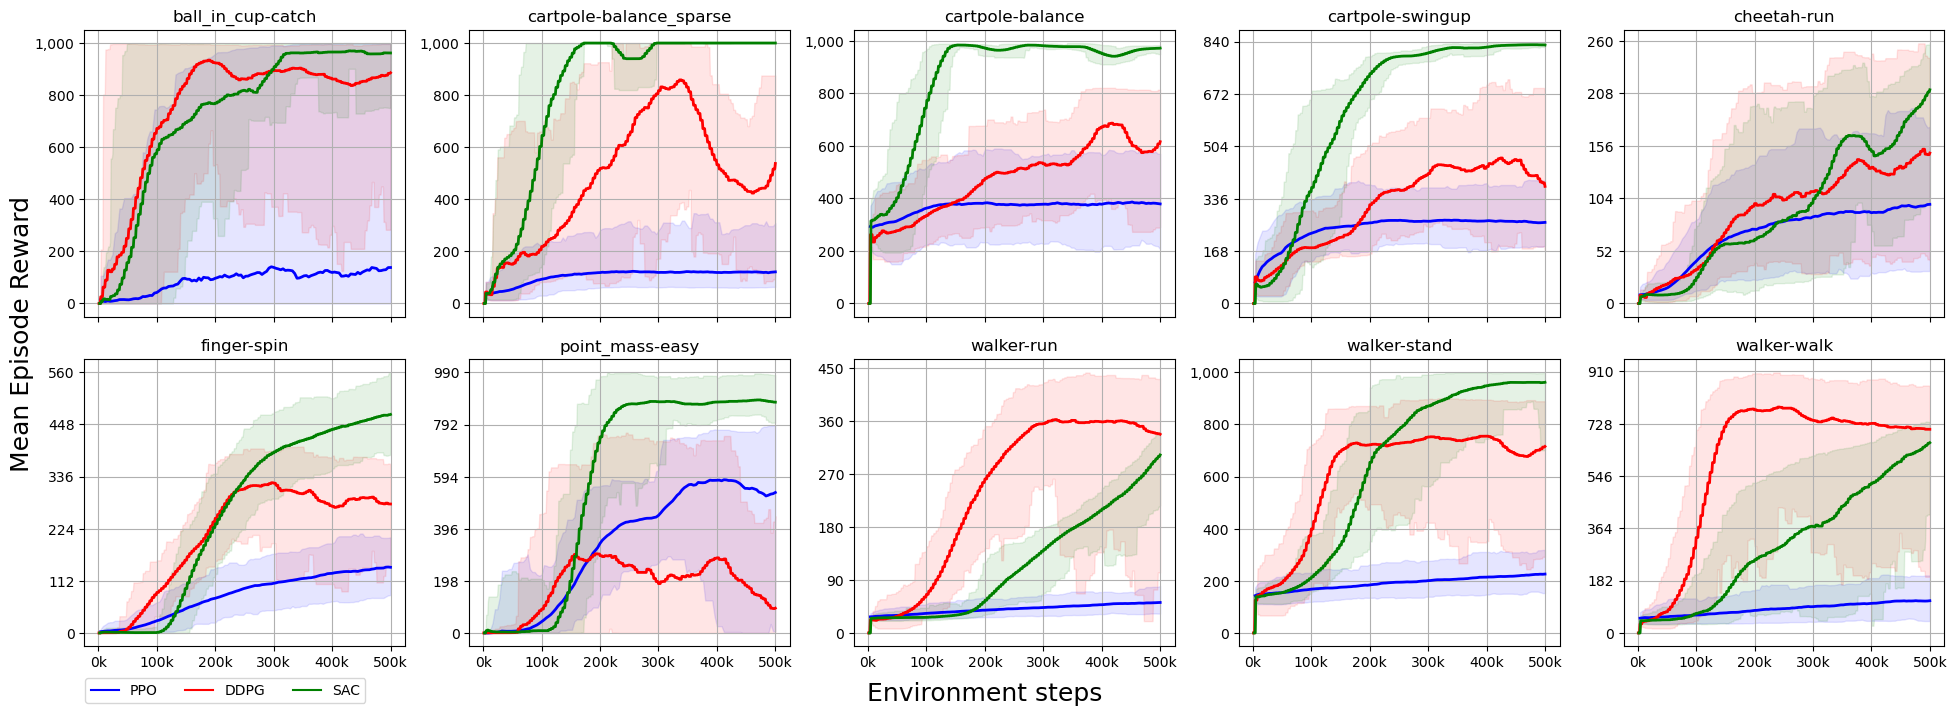

In [13]:
# -----------------------------------------
FIG_NAME = "learning_curves_selected"
FIG_ROWS = 2
FIG_COLS = 5
FIG_SIZE = (24, 8)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}
# -----------------------------------------

fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=FIG_SIZE)


def plot_data(
    algo: str, env_task: str, ax, data_to_plot, color: str, prev_max_value: float
) -> float:
    x = DATA_TO_PLOT[algo][env_task]["num_env_steps_sampled"]
    y = DATA_TO_PLOT[algo][env_task]["episode_reward_mean"]
    y_min = DATA_TO_PLOT[algo][env_task]["episode_reward_min"]
    y_max = DATA_TO_PLOT[algo][env_task]["episode_reward_max"]

    # Plot the data
    ax.plot(x, y, color=color, linewidth=2)
    ax.fill_between(x, y_min, y_max, color=color, alpha=0.1)

    # Set the x-axis major tick locations and labels
    x_major_ticks = np.linspace(
        0, round(x[-1], -2), 6
    )  # Specify the major tick positions
    ax.set_xticks(x_major_ticks)
    ax.set_xticklabels(
        [f"{int(tick * 1e-3):.0f}k" for tick in x_major_ticks]
    )  # Format labels as thousands separated with commas

    # Set the y-axis major tick locations and labels
    if np.max(y_max) > 10:
        y_max_rounded = np.ceil(np.max(y_max) / 10) * 10
    else:
        y_max_rounded = np.ceil(np.max(y_max))
    y_max_rounded = y_max_rounded if y_max_rounded > prev_max_value else prev_max_value
    y_major_ticks = np.linspace(0, y_max_rounded, 6)  # Specify the major tick positions
    ax.set_yticks(y_major_ticks)
    ax.set_yticklabels(
        [f"{int(tick):,}" for tick in y_major_ticks]
    )  # Format labels as thousands separated with commas

    return y_max_rounded


# Iterate over the axes and plot something on each of them
for i in range(FIG_ROWS):
    for j in range(FIG_COLS):
        idx = i * FIG_COLS + j
        if idx >= len(ENV_TASKS_SELECTED):
            continue
        env_task = ENV_TASKS_SELECTED[idx]
        ax = axes[i][j]
        # ax.plot([1, 2, 500000], [4, 5, 6], label="Data 1")
        # ax.plot([1, 2, 500000], [3, 7, 6], label="Data 2")
        # ax.plot([1, 2, 500000], [2, 8, 6], label="Data 3")
        try:
            max_val = 0.0
            for algo, color in ALGOS.items():
                max_val = plot_data(algo, env_task, ax, DATA_TO_PLOT, color, max_val)
        except ValueError as e:
            print(f"For {algo}@{env_task} an execption occured")
            raise e
        ax.set_title(env_task)

        # Add grid lines to the subplot
        ax.grid(True)

        #         # Set the range of the x-axis
        #         ax.set_xlim([0, 5e5])

        #         # Set the x-axis ticks format
        #         ax.xaxis.set_major_formatter(
        #             ticker.FuncFormatter(lambda x, pos: "{:.0f}k".format(x * 1e-3))
        #         )

        # if j == 0:
        #     ax.set_ylabel("Mean Episode Reward", rotation=90)

        # Turn off x-axis labels for all rows except the last one
        if i < FIG_ROWS - 1:
            ax.tick_params(labelbottom=False)

# Add a common ylabel for all rows
fig.text(
    0.099,
    0.5,
    "Mean Episode Reward",
    fontsize=18,
    ha="center",
    va="center",
    rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Add a common xlabel for all collumns
fig.text(
    0.5,
    0.05,
    "Environment steps",
    fontsize=18,
    ha="center",
    va="center",
    # rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Increase the horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.20, hspace=0.15)

# Add a legend below the subplots
handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]
fig.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="lower left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0.1225, 0.03),
)

result_file = OUTPUT_DIR.joinpath(f"{FIG_NAME}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

## Figure 2 - Generalizaion Gap Formalism

### Metrics implementations


In [14]:
def gen_gap_reward(train_reward: float, target_reward: float) -> float:
    return target_reward


def gen_gap_diff(train_reward: float, target_reward: float) -> float:
    return train_reward - target_reward


def gen_gap_ratio(train_reward: float, target_reward: float) -> float:
    return np.divide(target_reward, train_reward)


def gen_gap_db(train_reward: float, target_reward: float) -> float:
    value = np.divide(target_reward, train_reward)
    tolerance = 1e-6
    if np.isclose(value, 0, atol=tolerance).any():
        return 0.0
    return 10.0 * np.log10(value)


GEN_GAP_SCALARS = {
    "reward": gen_gap_reward,
    "diff": gen_gap_diff,
    "ratio": gen_gap_ratio,
    "db": gen_gap_db,
}


def gen_gap_mean_ln(train_reward: float, target_reward: np.array) -> float:
    ln_sum = np.sum(gen_gap_ln(train_reward, targe_reward))
    return np.divide(ln_sum, len(target_reward) - 1)

### Load evaluation data

In [15]:
import csv
from pathlib import Path

EVALUATION_RESULTS_PATH = Path("/mnt/ws/eval_workdir_results/output")
ENV_INSTANCES = 20
EVALUATION_RUNS = 30
ENV_TASKS_EVALUATIONS = 5 * EVALUATION_RUNS
ALGOS = ["PPO", "DDPG", "SAC"]


def load_eval_data(input_dir: Path) -> Dict:
    results = {}
    for algo in ALGOS:
        results[algo] = load_algorithm(algo, input_dir)
    return results


def load_algorithm(algo: str, input_dir: Path) -> Dict:
    results = {}
    for env_task in ENV_TASKS:
        results[env_task] = load_env_task(algo, env_task, input_dir)
    return results


def load_env_task(algo: str, env_task: str, input_dir: Path) -> Dict:
    results = {}
    with input_dir.joinpath(f"{algo}_{env_task}.csv").open("r") as csv_file:
        csv_reader = csv.DictReader(csv_file)

        for row in csv_reader:
            env_instance = int(row["step"])
            if results.get(env_instance, None) is None:
                results[env_instance] = np.zeros(ENV_TASKS_EVALUATIONS)
                seed_cnt = 0

            for idx, (col, val) in enumerate(row.items()):
                if col == "step" or col == "seed":
                    continue
                datapoint_idx = (idx - 2) + seed_cnt * EVALUATION_RUNS
                results[env_instance][datapoint_idx] = val
            seed_cnt += 1

    return results

In [16]:
EVAL_DATA = load_eval_data(EVALUATION_RESULTS_PATH)

In [17]:
def assert_print(val1, val2, text: str) -> None:
    def bool2ok(x: bool) -> str:
        return " OK " if x else "NOK "

    ok = bool2ok(val1 == val2)
    print(f"[{ok}] {text}: {val1}/{val2}")


print(f"CHECKING INTEGRITY OF LOADED EVALUATION RESULTS:")

assert_print(len(EVAL_DATA), NUMBER_OF_ALGOS, "> REGISTERED ALGORITHMS")
print("################################################################")
for k, v in EVAL_DATA.items():
    assert_print(len(v), NUMBER_OF_ENV_TASKS, f">>> [{k}] env-tasks")
    for env_task, env_instances in v.items():
        assert_print(
            len(env_instances),
            ENV_INSTANCES,
            f">>>>> {env_task} contains env instances",
        )
        for idx, data in env_instances.items():
            assert (
                len(data) == ENV_TASKS_EVALUATIONS
            ), f"Amount of datapoints mismatch env_instance: {idx}"
    print("################################################################")

CHECKING INTEGRITY OF LOADED EVALUATION RESULTS:
[ OK ] > REGISTERED ALGORITHMS: 3/3
################################################################
[ OK ] >>> [PPO] env-tasks: 28/28
[ OK ] >>>>> acrobot-swingup_sparse contains env instances: 20/20
[ OK ] >>>>> acrobot-swingup contains env instances: 20/20
[ OK ] >>>>> ball_in_cup-catch contains env instances: 20/20
[ OK ] >>>>> cartpole-balance_sparse contains env instances: 20/20
[ OK ] >>>>> cartpole-balance contains env instances: 20/20
[ OK ] >>>>> cartpole-swingup_sparse contains env instances: 20/20
[ OK ] >>>>> cartpole-swingup contains env instances: 20/20
[ OK ] >>>>> cheetah-run contains env instances: 20/20
[ OK ] >>>>> finger-spin contains env instances: 20/20
[ OK ] >>>>> finger-turn_easy contains env instances: 20/20
[ OK ] >>>>> finger-turn_hard contains env instances: 20/20
[ OK ] >>>>> fish-swim contains env instances: 20/20
[ OK ] >>>>> fish-upright contains env instances: 20/20
[ OK ] >>>>> hopper-hop contains env 

### Generate one plot for each metric

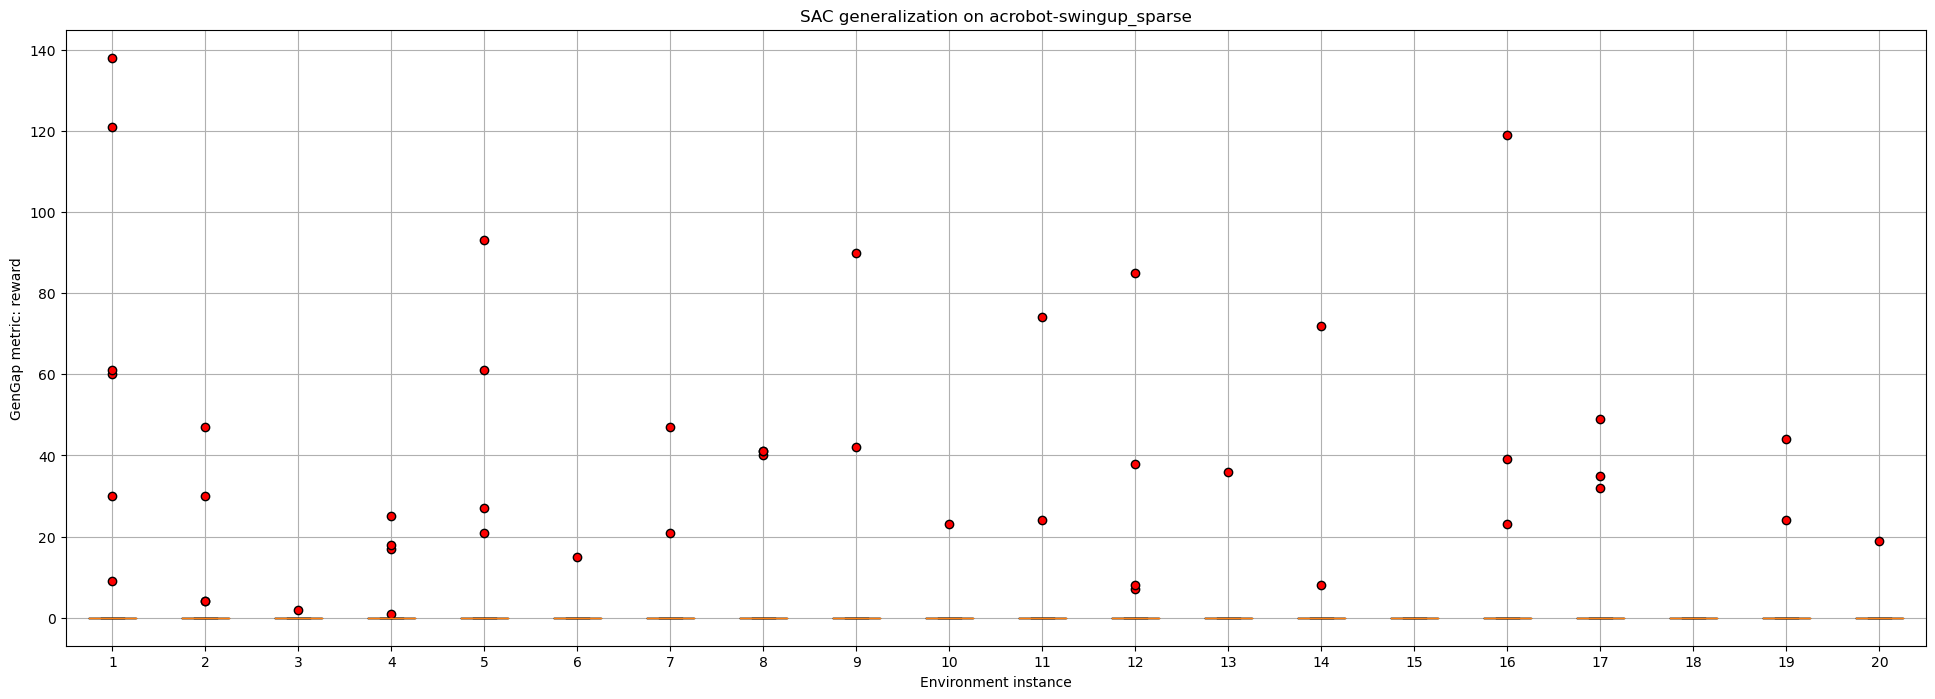

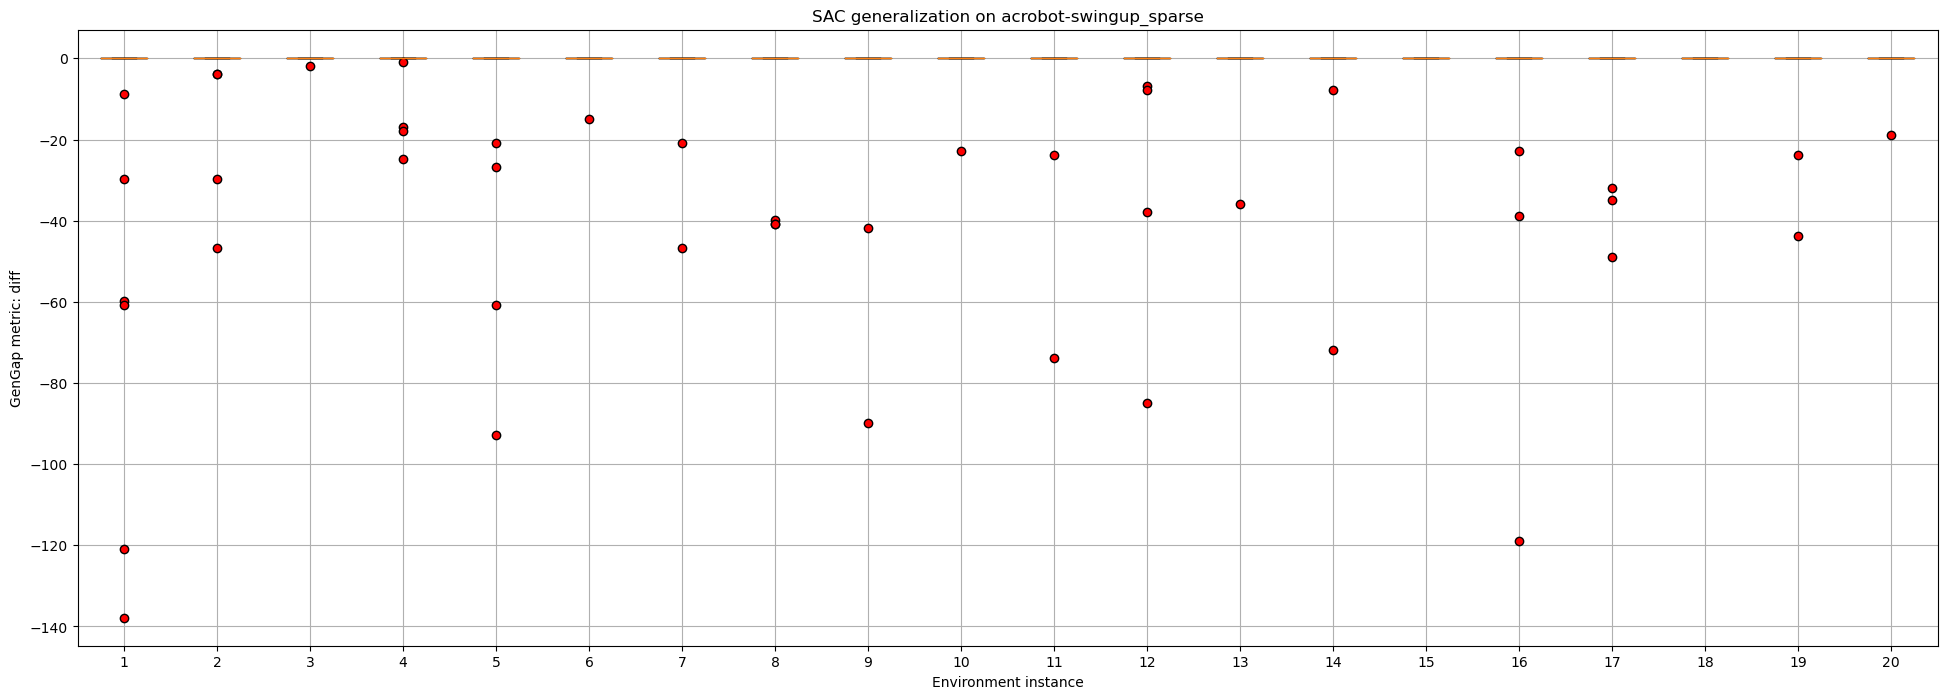

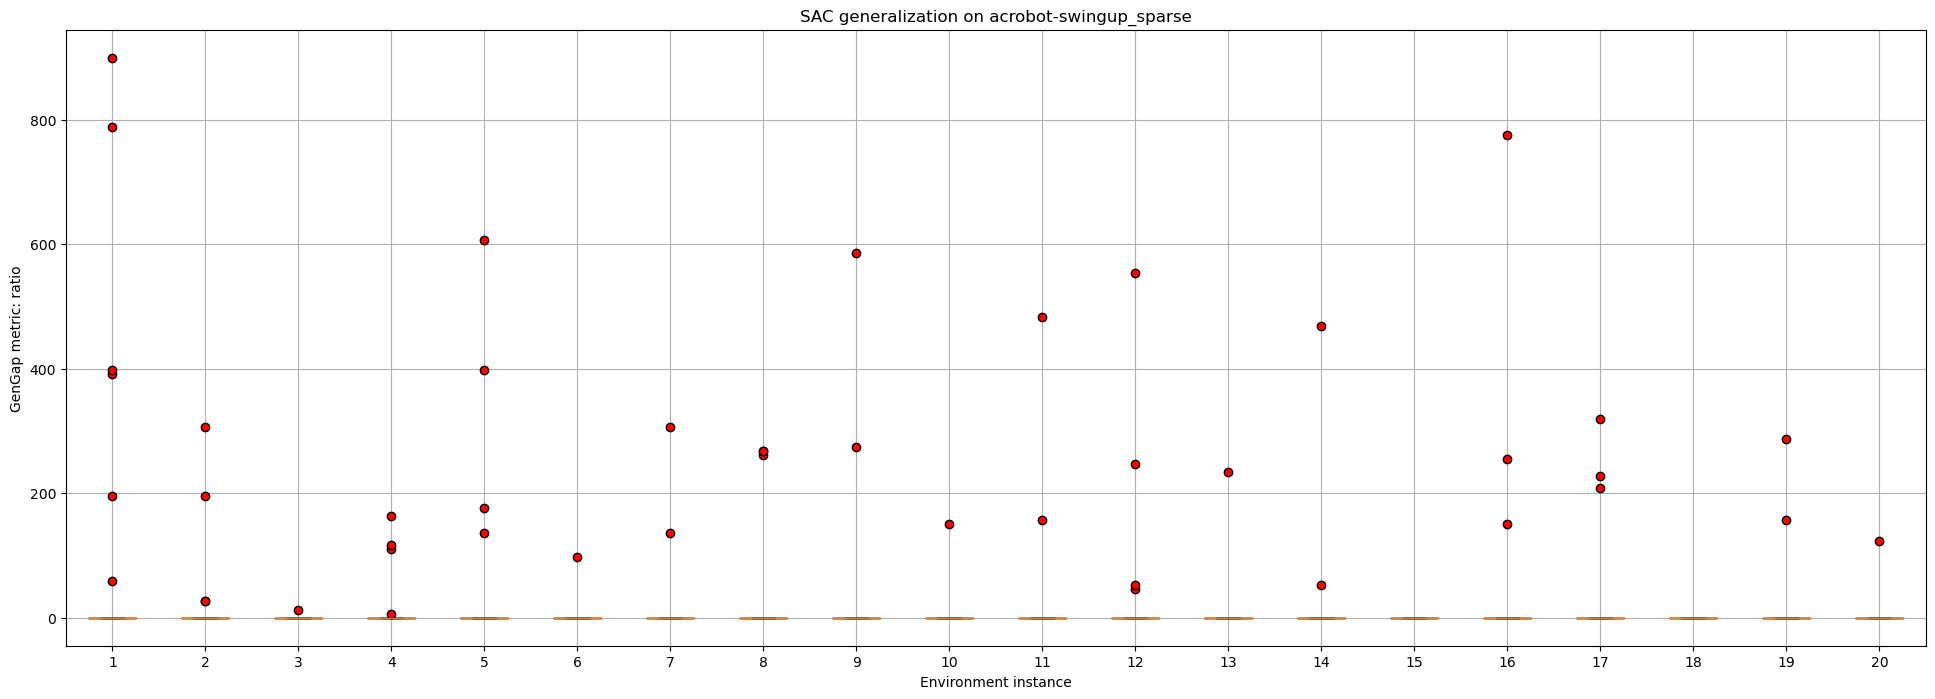

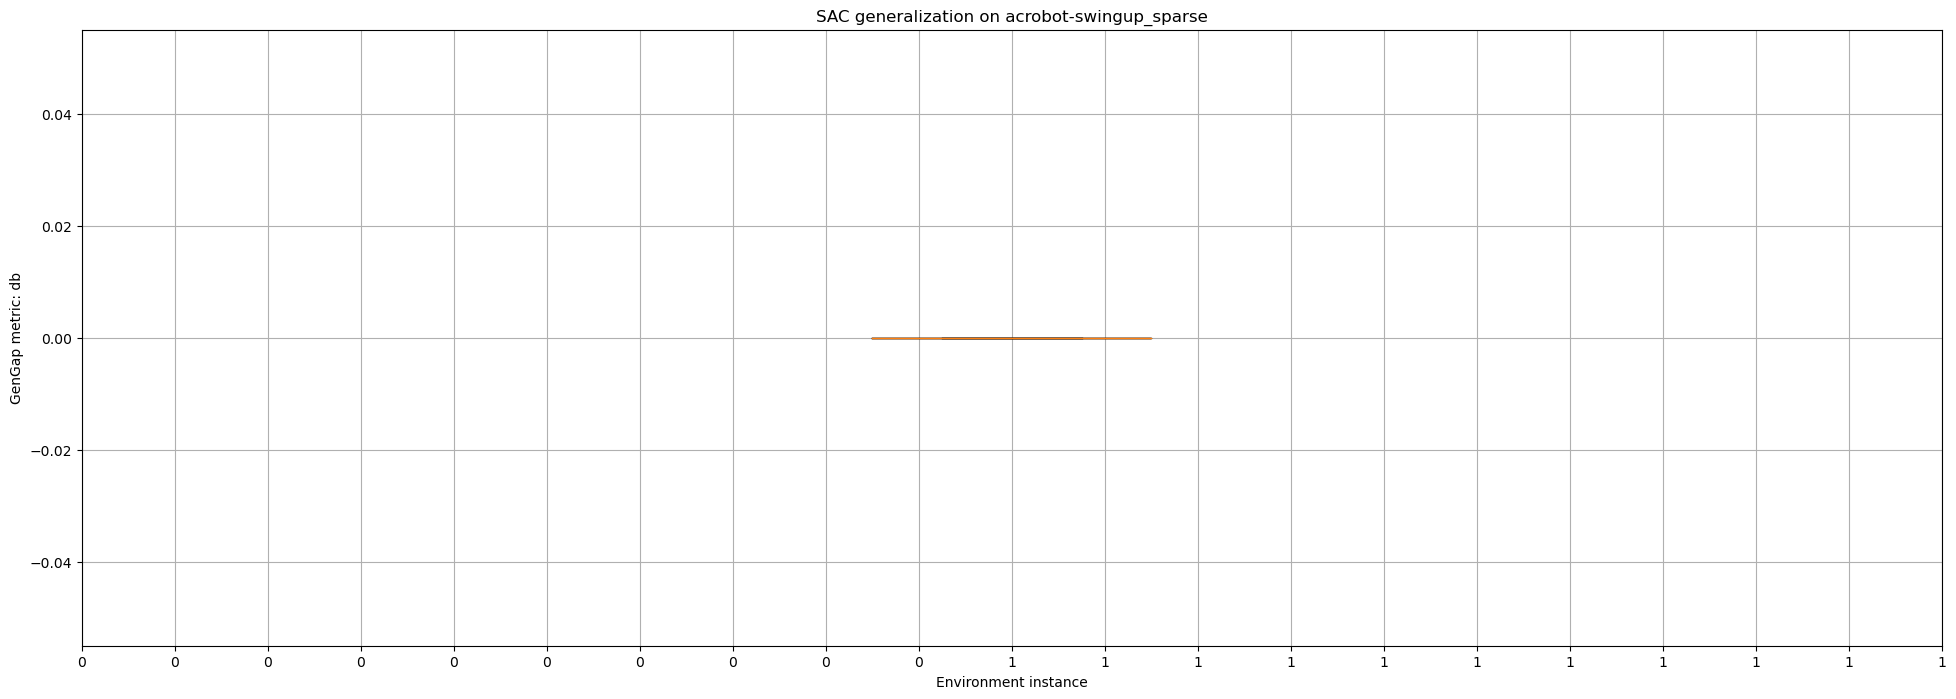

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

algo = "SAC"
env_task = "acrobot-swingup_sparse"

train_reward = np.mean(EVAL_DATA[algo][env_task][9])
for gen_gap_name, gen_gap_fn in GEN_GAP_SCALARS.items():
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
    ax = axes

    data = [gen_gap_fn(train_reward, x) for x in EVAL_DATA[algo][env_task].values()]

    ax.boxplot(
        data,
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
        },
    )
    plt.xlabel("Environment instance")
    plt.ylabel(f"GenGap metric: {gen_gap_name}")
    plt.title(f"{algo} generalization on {env_task}")

    # Format x-axis major ticks
    def format_func(value, tick_number):
        if value < 0 or value > len(data):
            return ""
        else:
            return str(int(value))  # Adjust the label numbering if needed

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=20))

    # Display the plot
    plt.grid(True)
    plt.show()

### Generate aggregate plots

In [20]:
def plot_data(
    ax, data_to_plot, color: str, outliers: bool = False, vertical: bool = True
) -> None:
    # Plot the data
    ax.boxplot(
        data_to_plot,
        vert=vertical,
        sym="." if outliers else "",
        boxprops={"color": color, "linewidth": 0.5},
        whiskerprops={"color": color},
        medianprops={"color": color, "linewidth": 0.5},
        flierprops={
            "marker": ".",
            "markerfacecolor": color,
            "markeredgecolor": color,
        },
    )


def format_x_axis(ax) -> None:
    # Format x-axis major ticks
    def format_func(value, tick_number):
        if value < 0 or value > len(data):
            return ""
        else:
            return str(int(value))  # Adjust the label numbering if needed

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=20))


def baseline_reward(eval_data: Dict, algo: str, env_task: str) -> float:
    result = np.mean(eval_data[algo][env_task][9])
    return result if not result == 0.0 else 0.000001

#### Generate horizontal charts

In [21]:
ENV_TASKS_PRESENTATION = (
    # # "acrobot-swingup_sparse",
    # # "acrobot-swingup",
    # "ball_in_cup-catch",
    # "cartpole-balance_sparse",
    # "cartpole-balance",
    # # "cartpole-swingup_sparse",
    # "cartpole-swingup",
    # "cheetah-run",
    "finger-spin",
    # "finger-turn_easy",
    # "finger-turn_hard",
    # "fish-swim",
    # "fish-upright",
    # "hopper-hop",
    # "hopper-stand",
    # "humanoid-run",
    # "humanoid-stand",
    # "humanoid-walk",
    # "manipulator-bring_ball",
    # "pendulum-swingup",
    "point_mass-easy",
    # "reacher-easy",
    # "reacher-hard",
    # "swimmer-swimmer15",
    # "swimmer-swimmer6",
    "walker-run",
    "walker-stand",
    "walker-walk",
)

ENV_TASKS_NOT_PRESENTATION = (
    # "acrobot-swingup_sparse",
    # "acrobot-swingup",
    "ball_in_cup-catch",
    "cartpole-balance_sparse",
    "cartpole-balance",
    # "cartpole-swingup_sparse",
    "cartpole-swingup",
    "cheetah-run",
    # "finger-spin",
    # # "finger-turn_easy",
    # # "finger-turn_hard",
    # # "fish-swim",
    # # "fish-upright",
    # # "hopper-hop",
    # # "hopper-stand",
    # # "humanoid-run",
    # # "humanoid-stand",
    # # "humanoid-walk",
    # # "manipulator-bring_ball",
    # # "pendulum-swingup",
    # "point_mass-easy",
    # # "reacher-easy",
    # # "reacher-hard",
    # # "swimmer-swimmer15",
    # # "swimmer-swimmer6",
    # "walker-run",
    # "walker-stand",
    # "walker-walk",
)

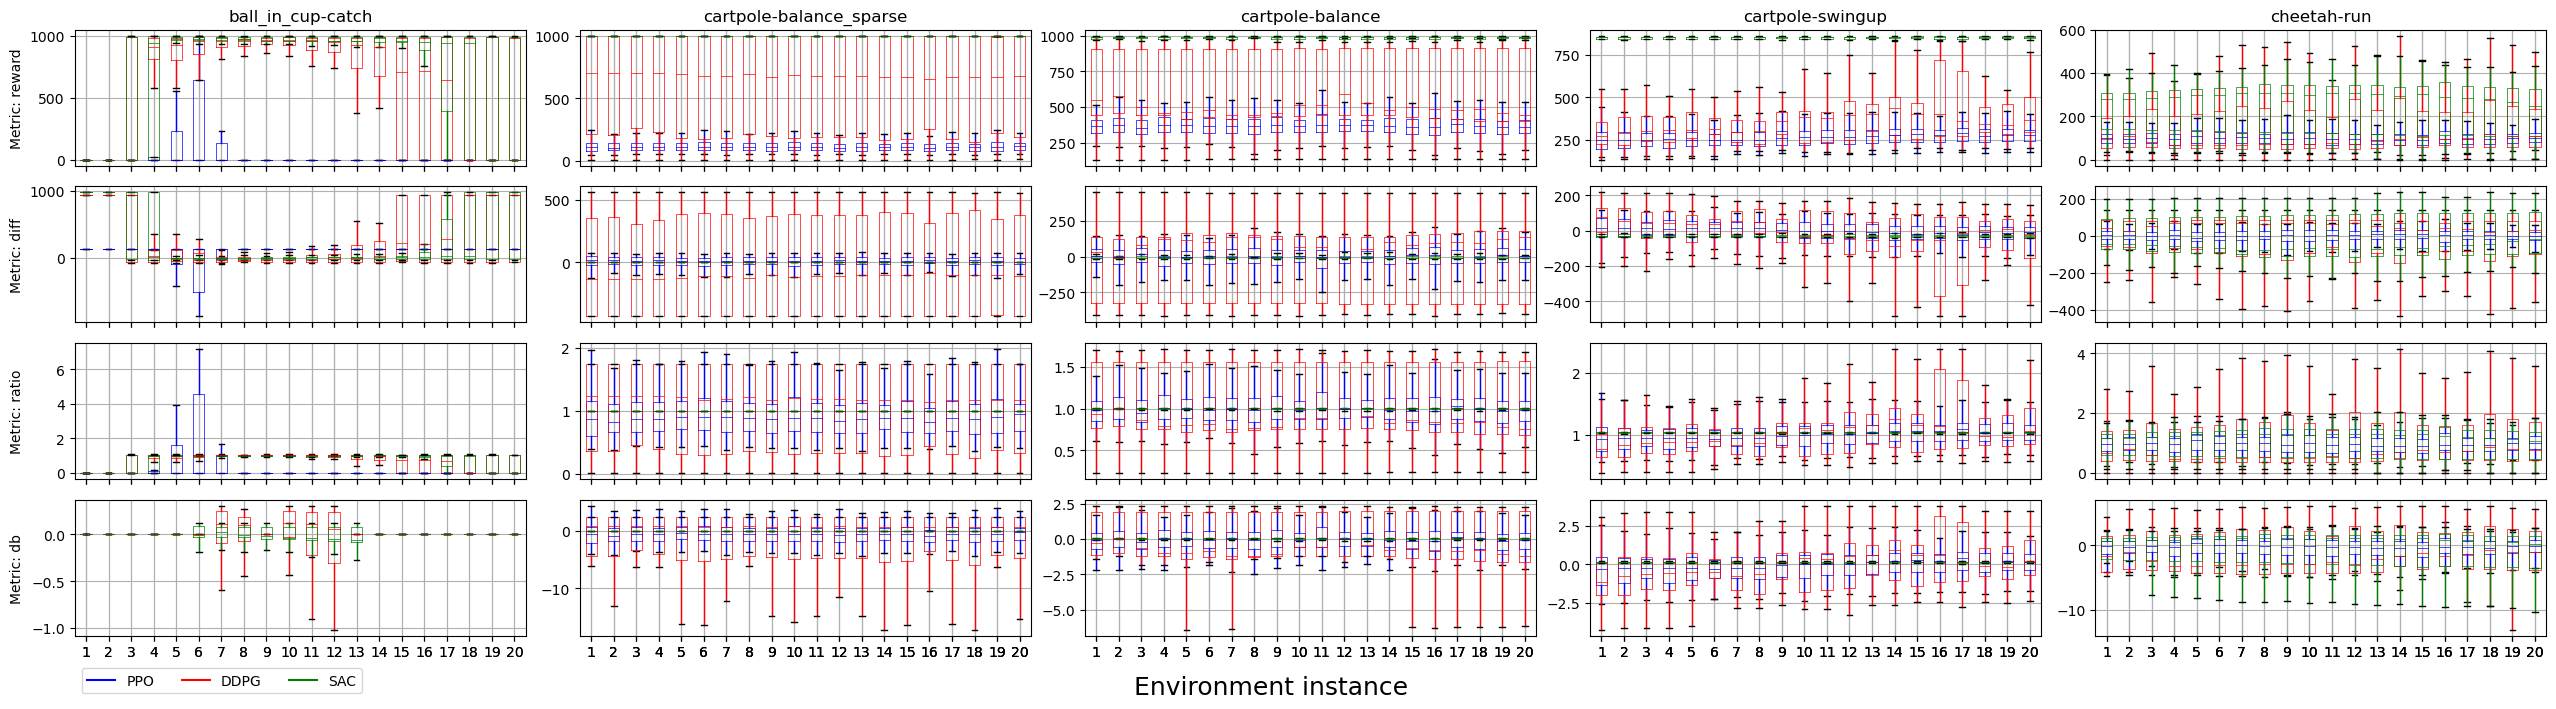

In [22]:
from typing import Callable

FIG_ROWS = len(GEN_GAP_SCALARS)
FIG_COLS = len(ENV_TASKS_NOT_PRESENTATION)
cm = 1 / 2.54  # centimeters in inches
FIG_SIZE = (81 * cm, 20 * cm)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}
ENV_TASKS_NAMES = ENV_TASKS_NOT_PRESENTATION

fig_name = f"gen_metrics_appendix"
fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=FIG_SIZE)

for row, (gen_gap_name, gen_gap_fn) in enumerate(GEN_GAP_SCALARS.items()):
    for col in range(FIG_COLS):
        env_task = ENV_TASKS_NAMES[col]

        try:
            ax = axes[row][col]
        except TypeError:
            ax = axes[col]

        for algo, color in ALGOS.items():
            train_reward = baseline_reward(EVAL_DATA, algo, env_task)
            data = [
                gen_gap_fn(train_reward, x) for x in EVAL_DATA[algo][env_task].values()
            ]
            max_val = plot_data(ax, data, color)

        ax.grid(True)

        if row == 0:
            ax.set_title(env_task)

        # Turn off x-axis labels for all rows except the last one
        if row + 1 < FIG_ROWS:
            ax.tick_params(labelbottom=False)

        if col == 0:
            ax.set_ylabel(f"Metric: {gen_gap_name}")

# Add a common xlabel for all collumns
fig.text(
    0.5,
    0.045,
    "Environment instance",
    fontsize=18,
    ha="center",
    va="center",
    # rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Increase the horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.12, hspace=0.15)

# Add a legend below the subplots
handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]
fig.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="lower left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0.125, 0.028),
)

fig.align_ylabels(axes[:, 0])

result_file = OUTPUT_DIR.joinpath(f"{fig_name}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

#### Generate agregated charts

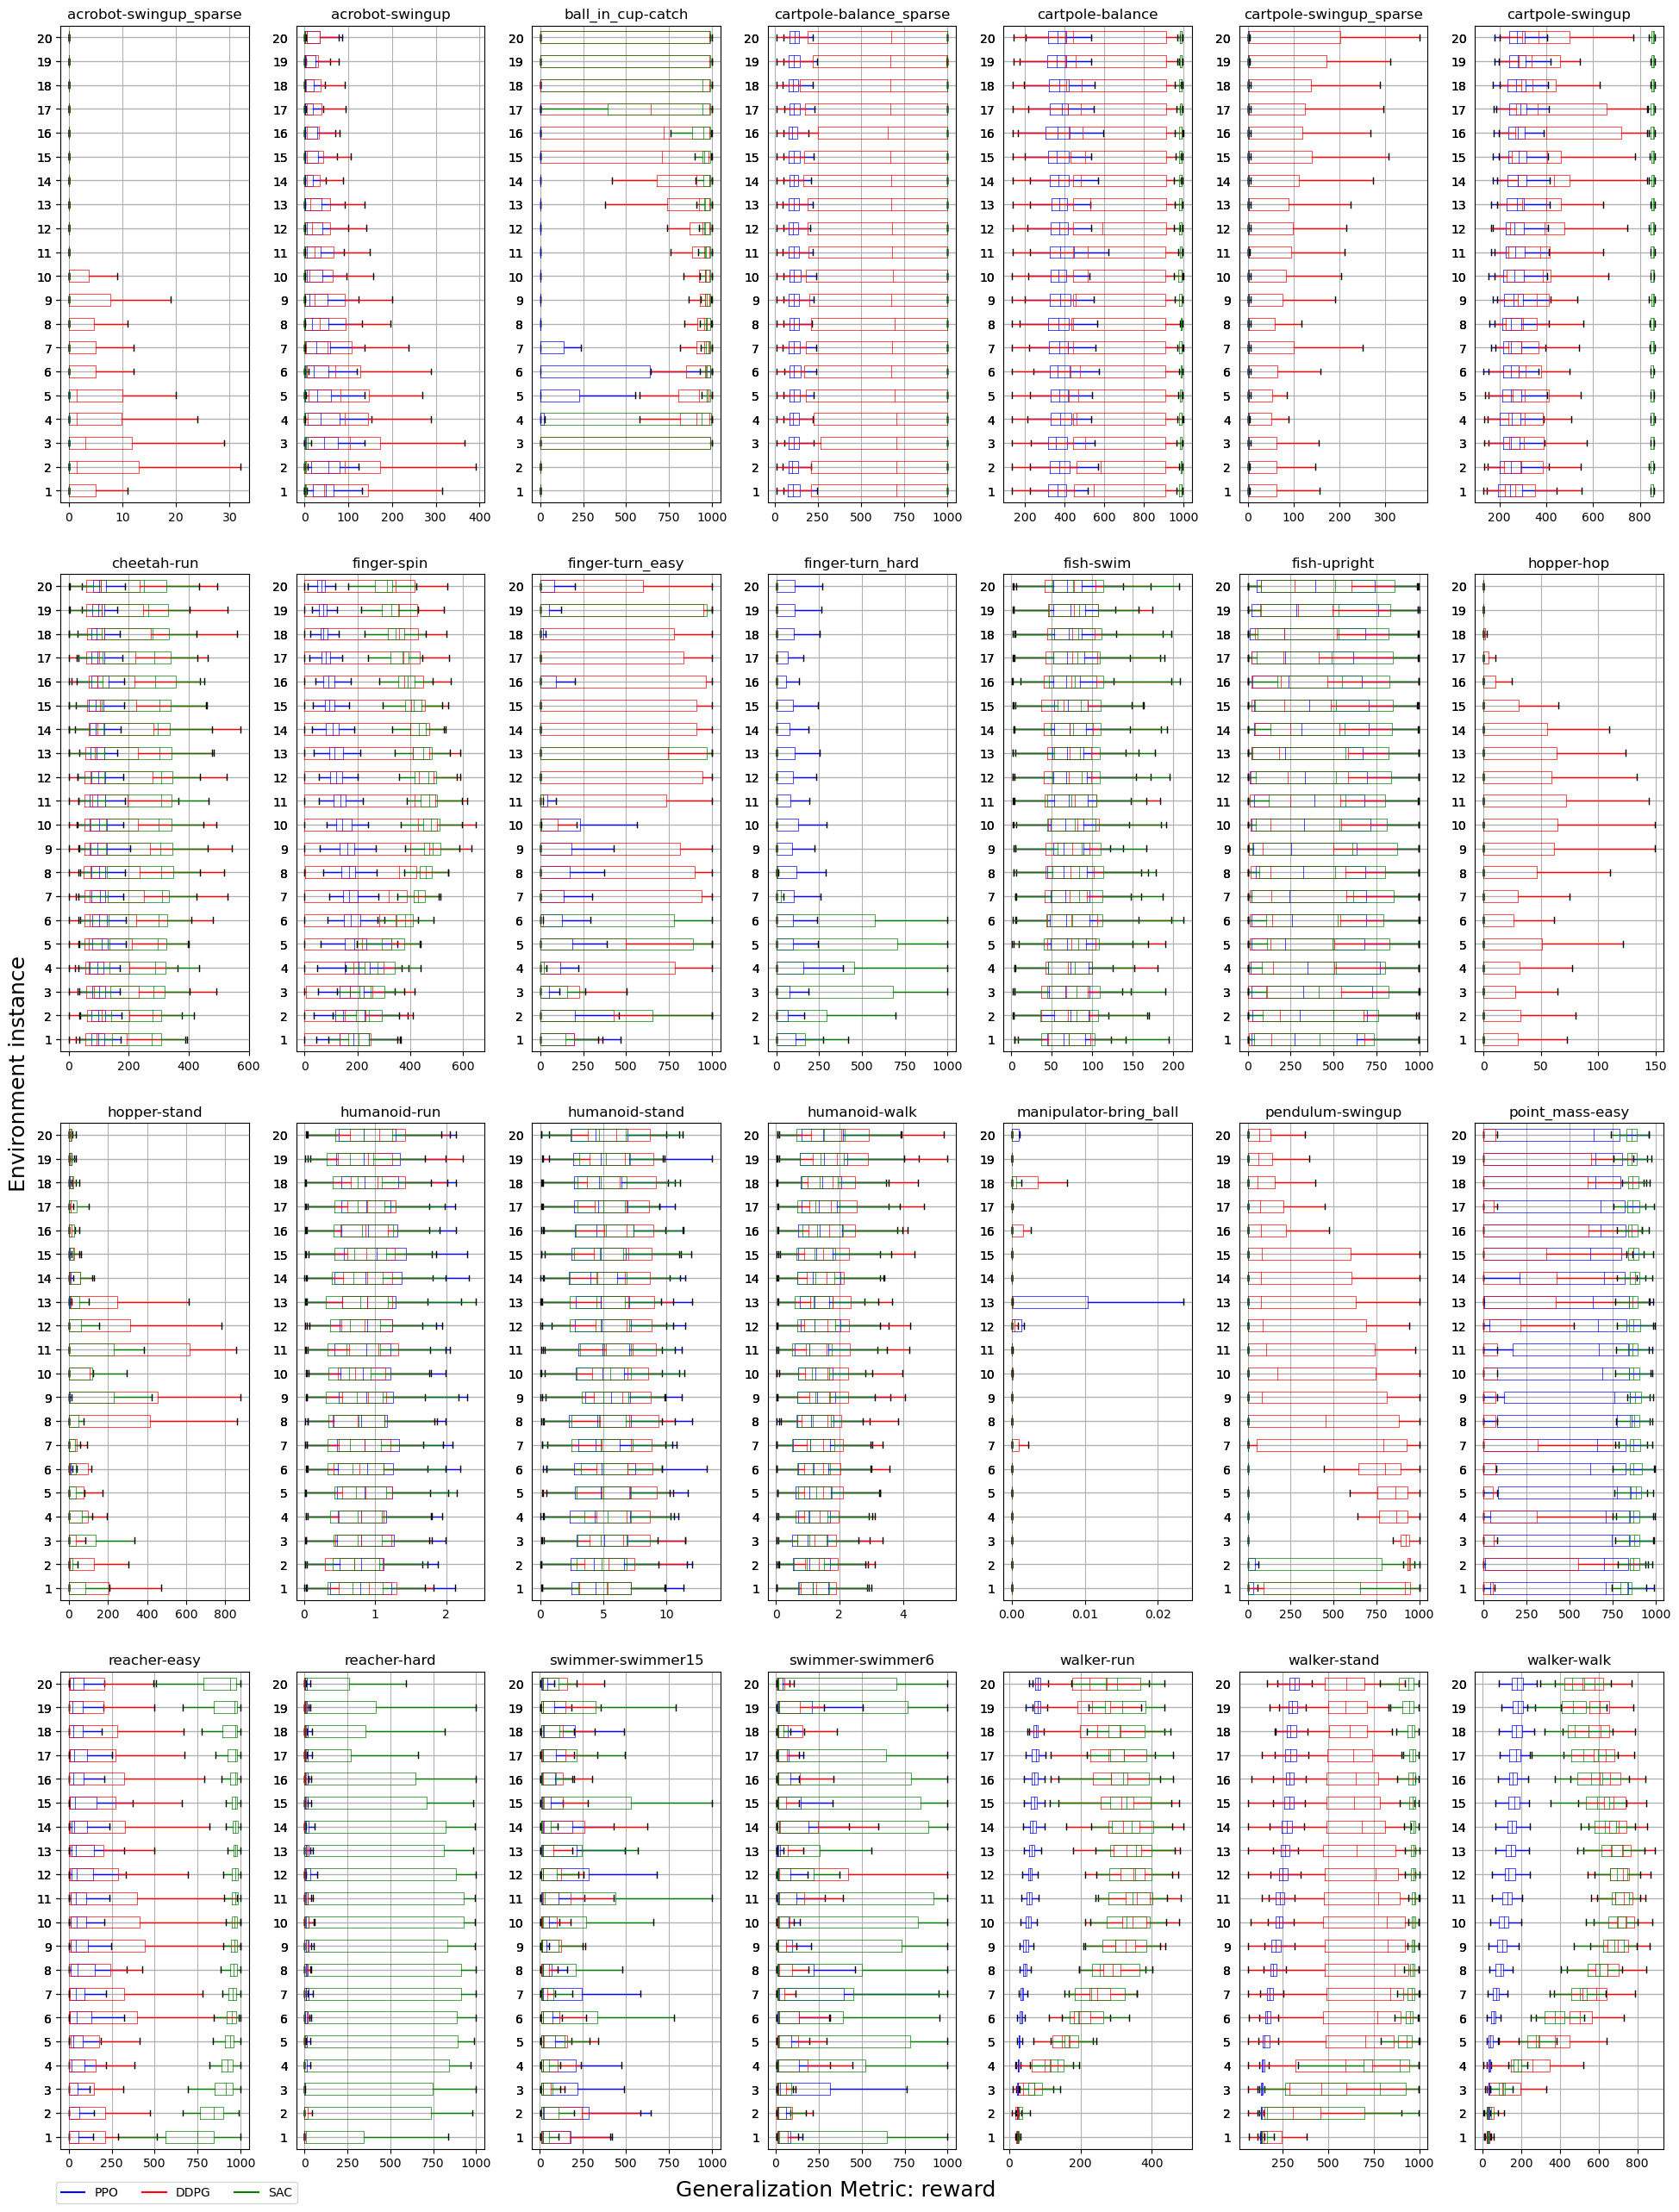

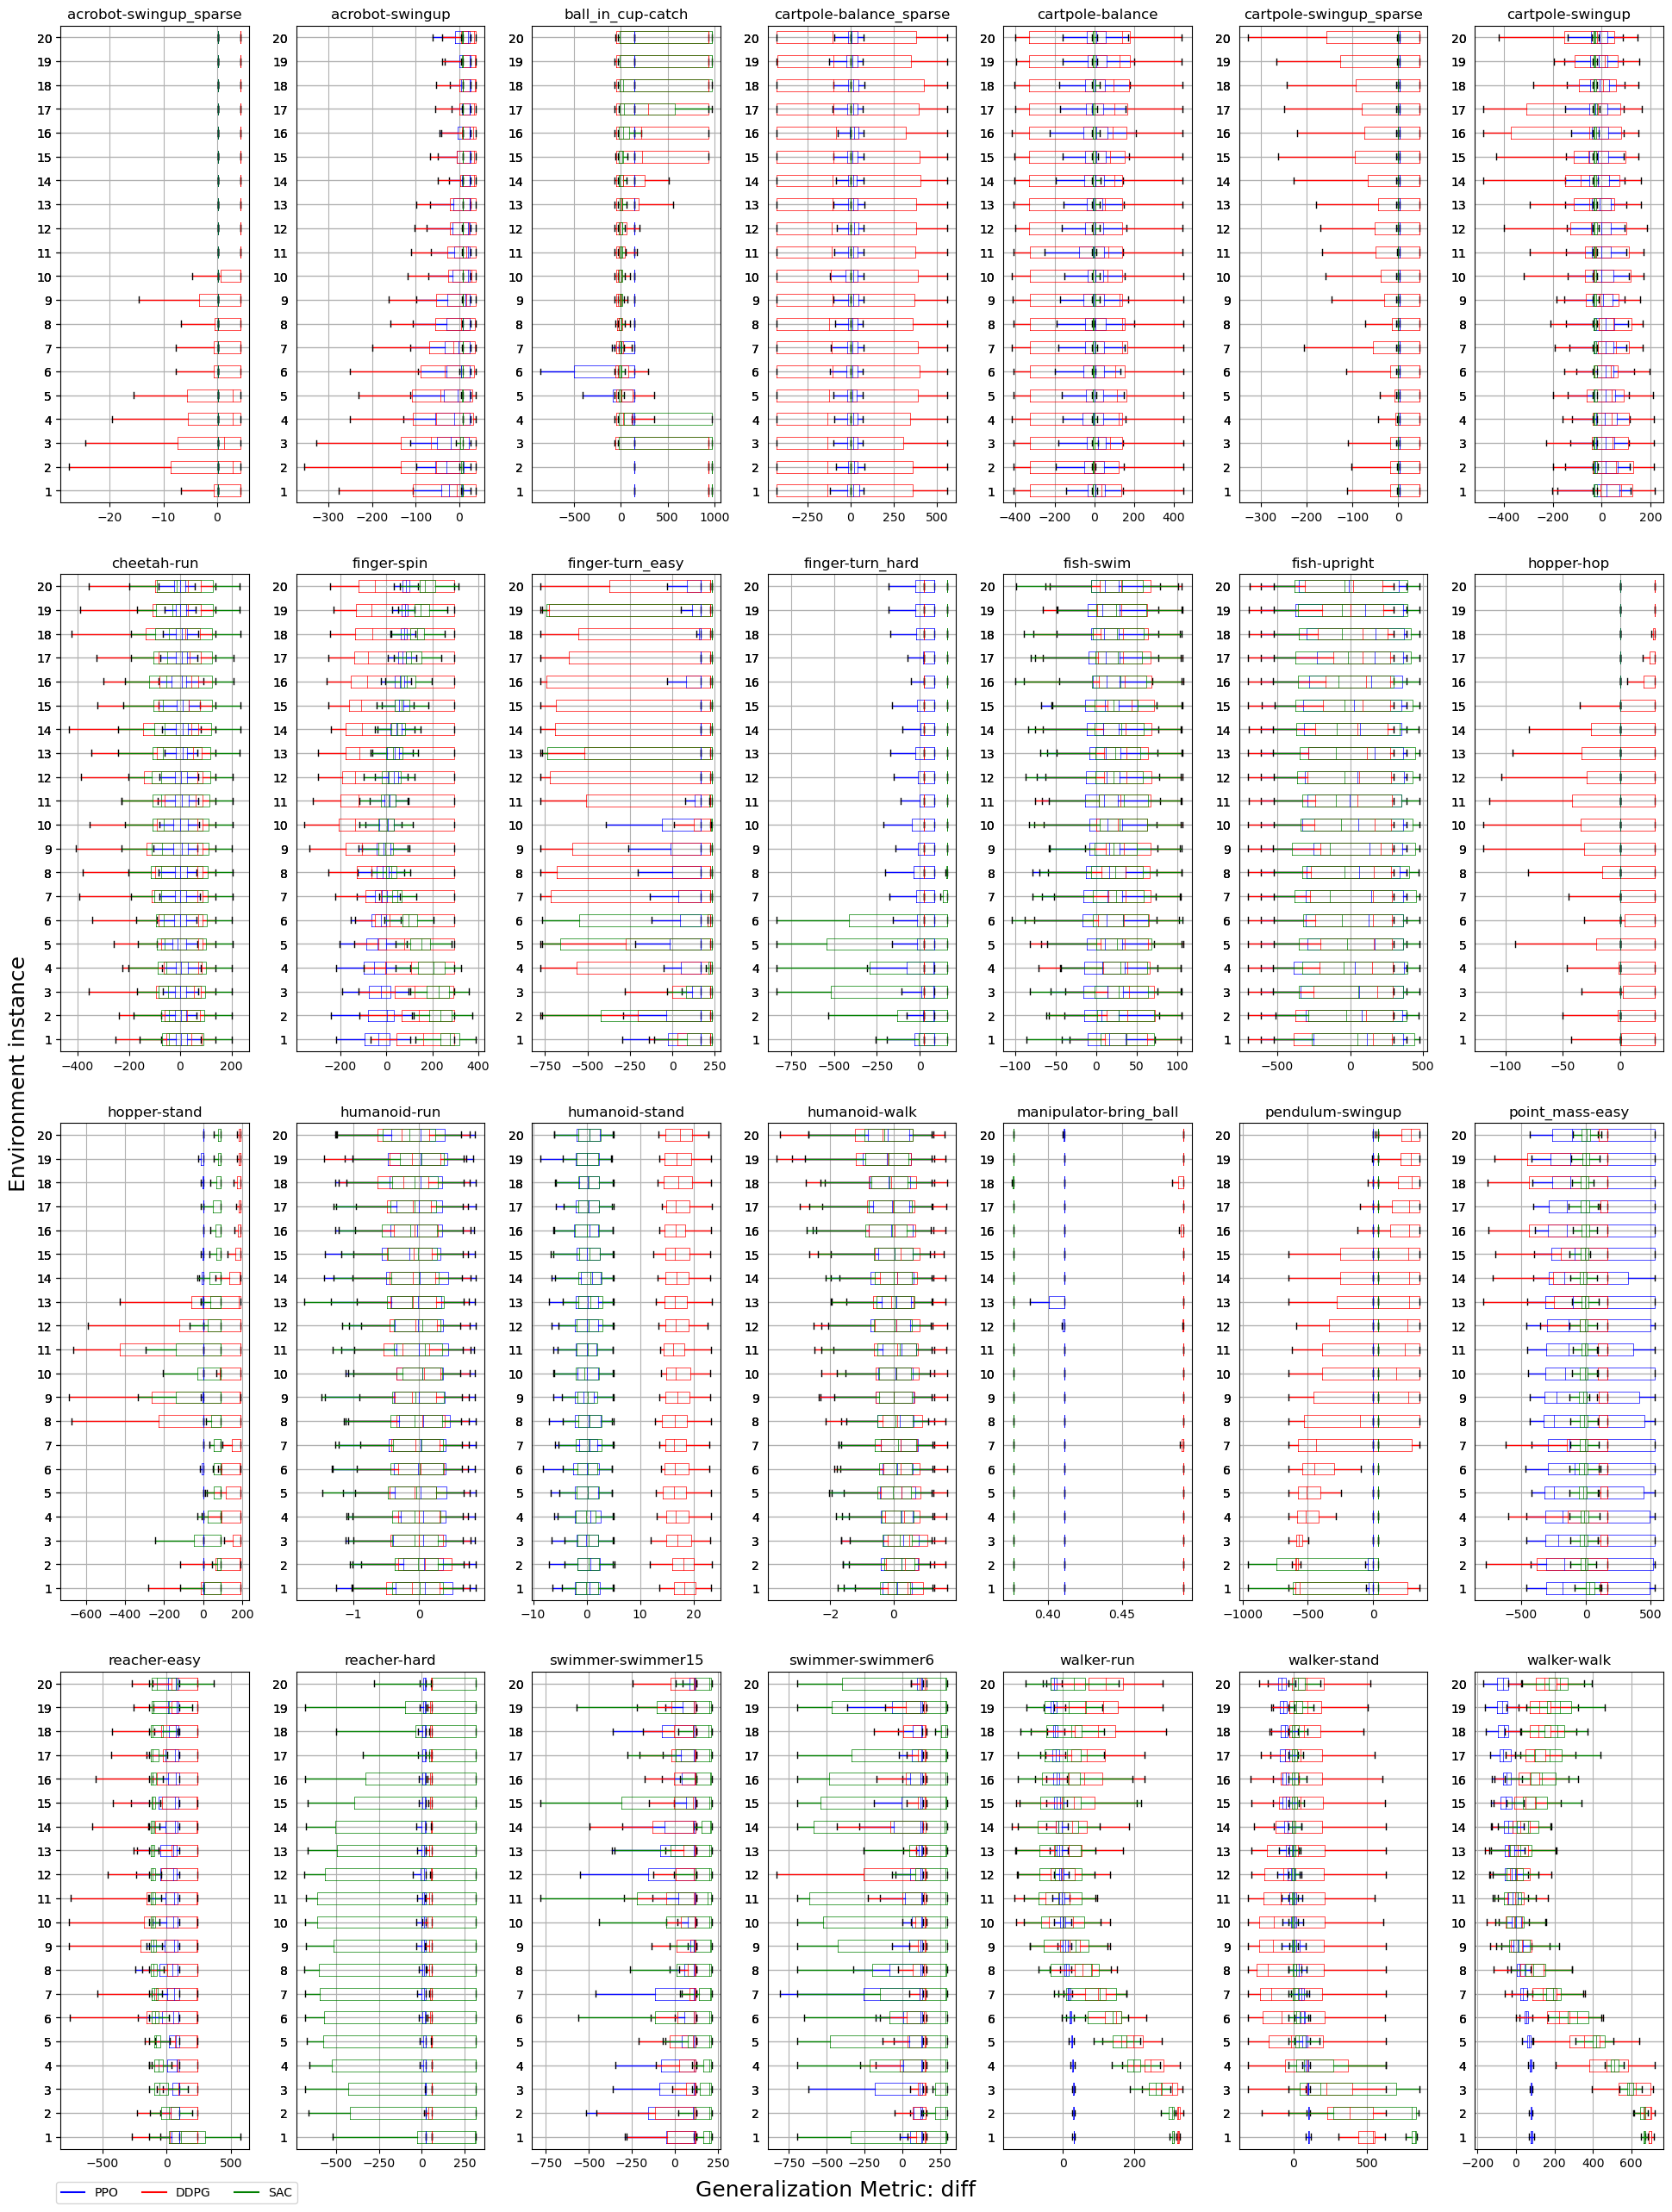

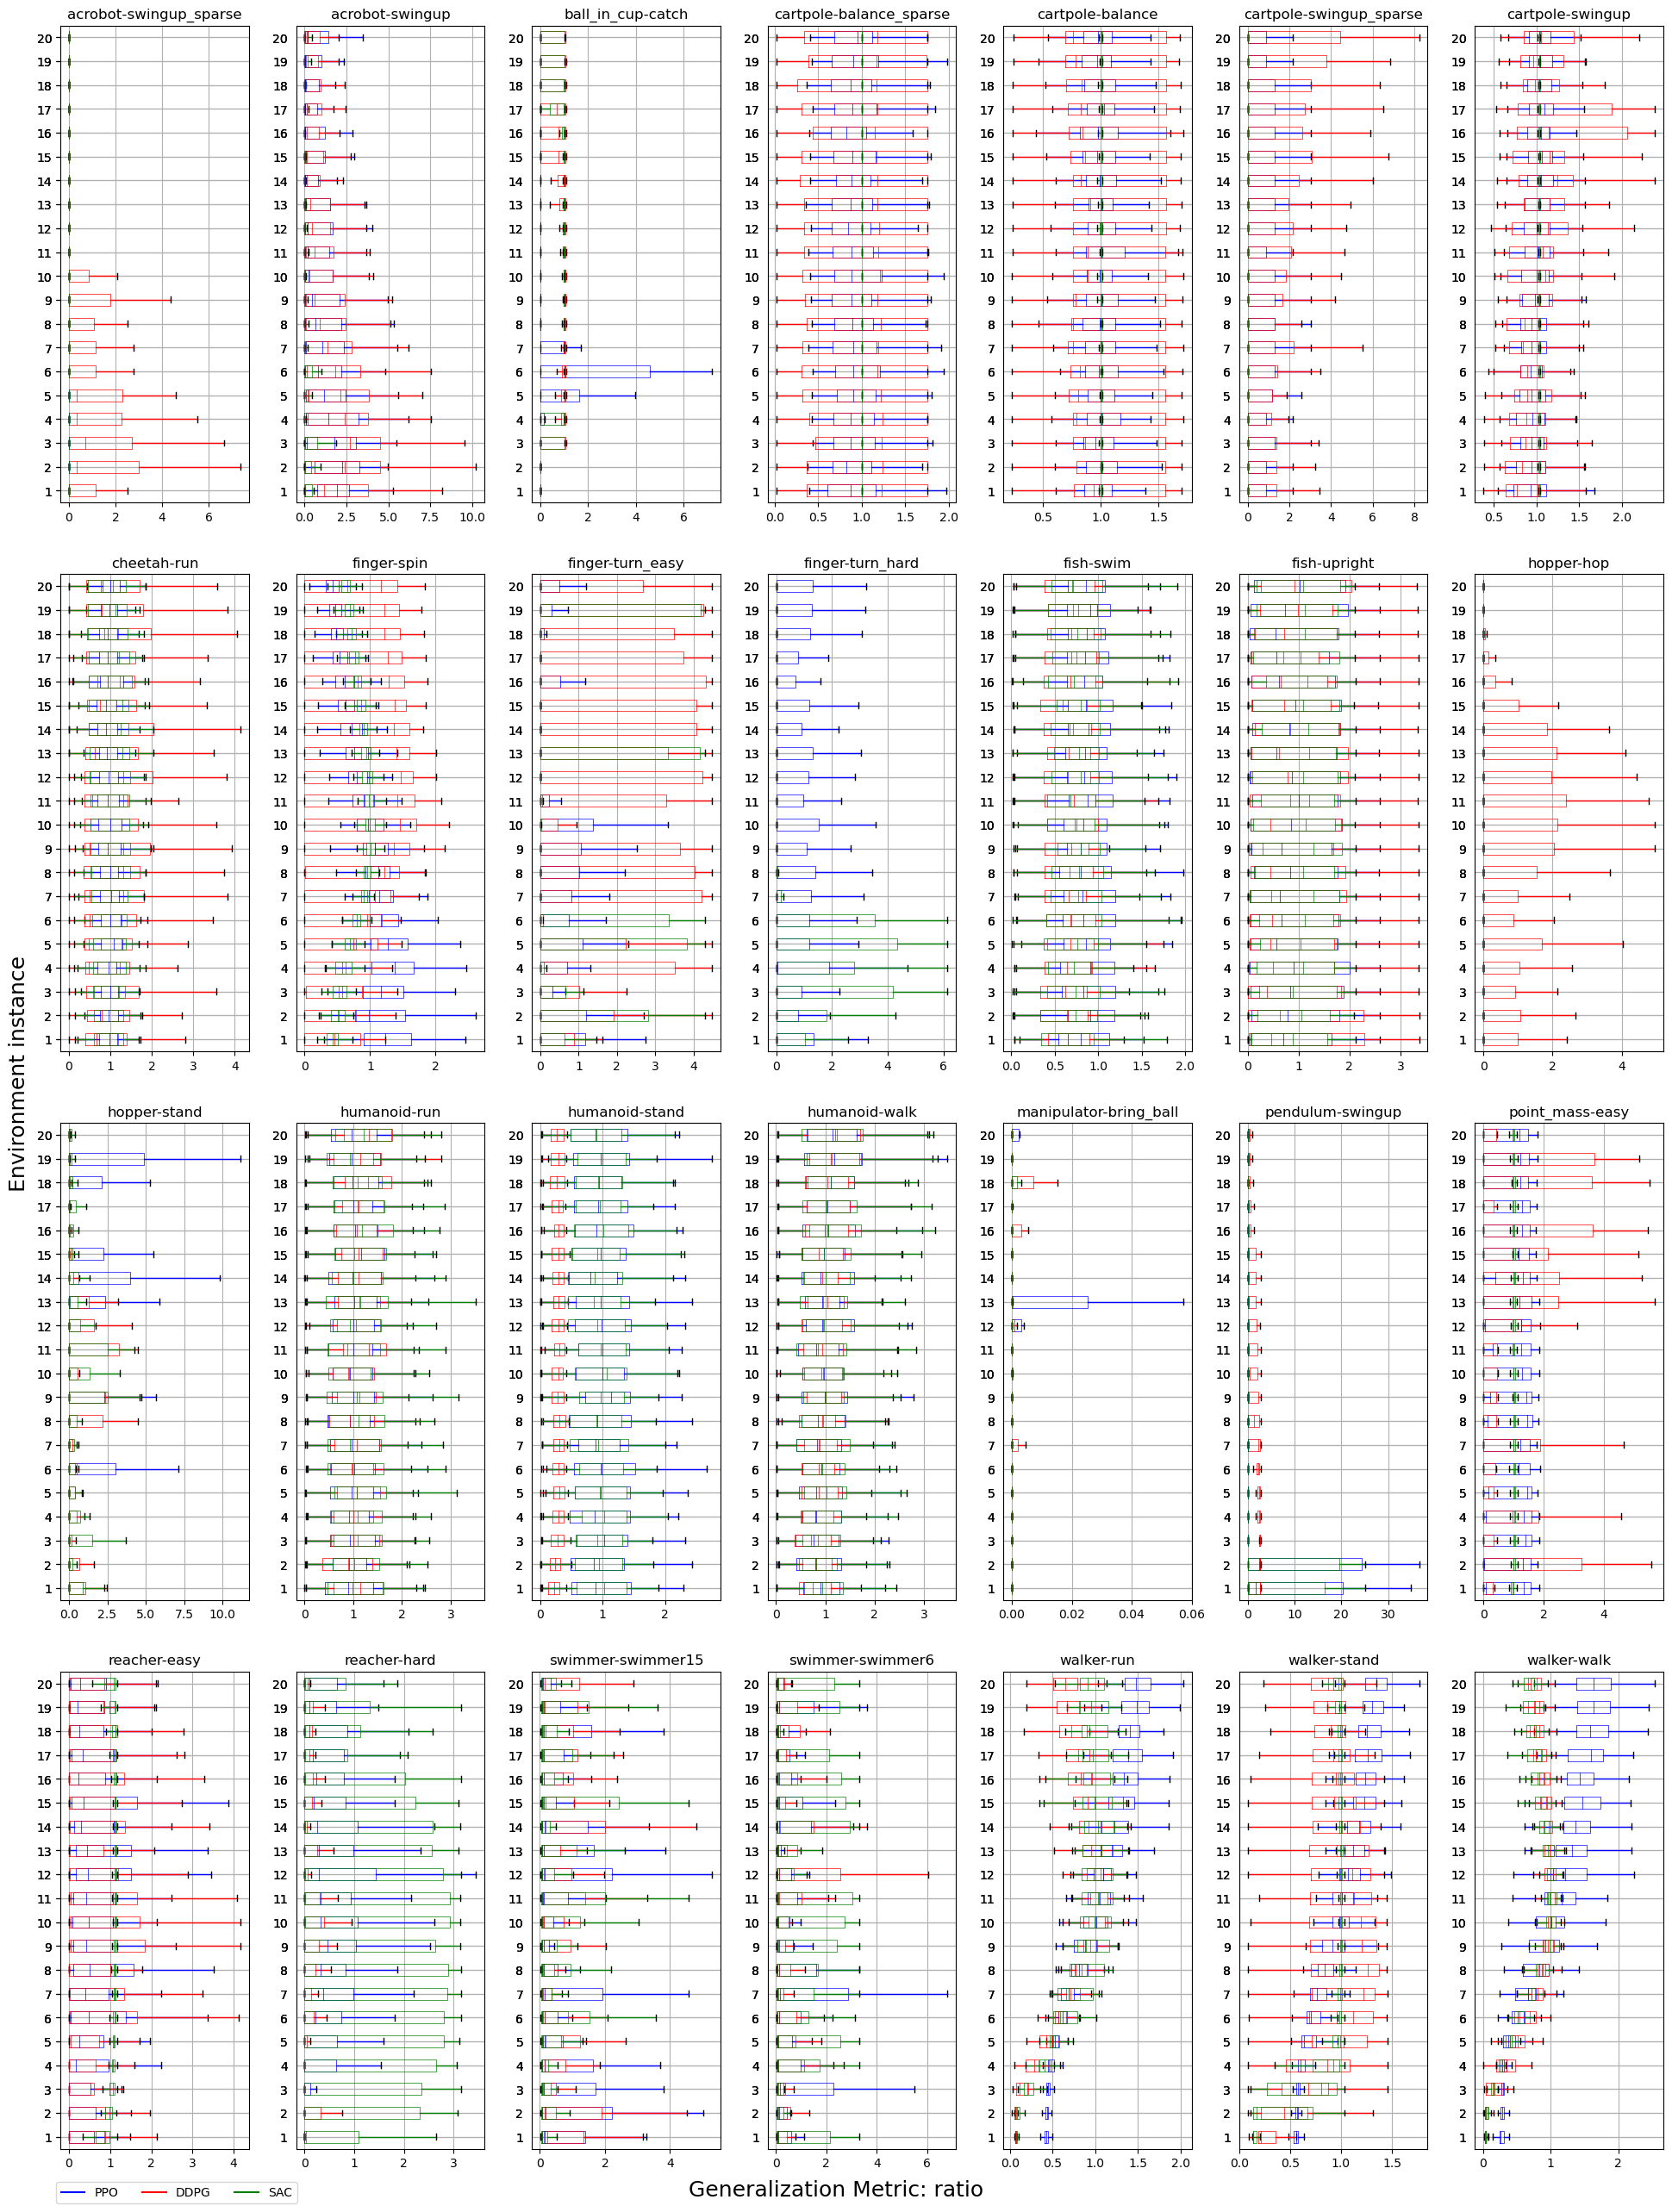

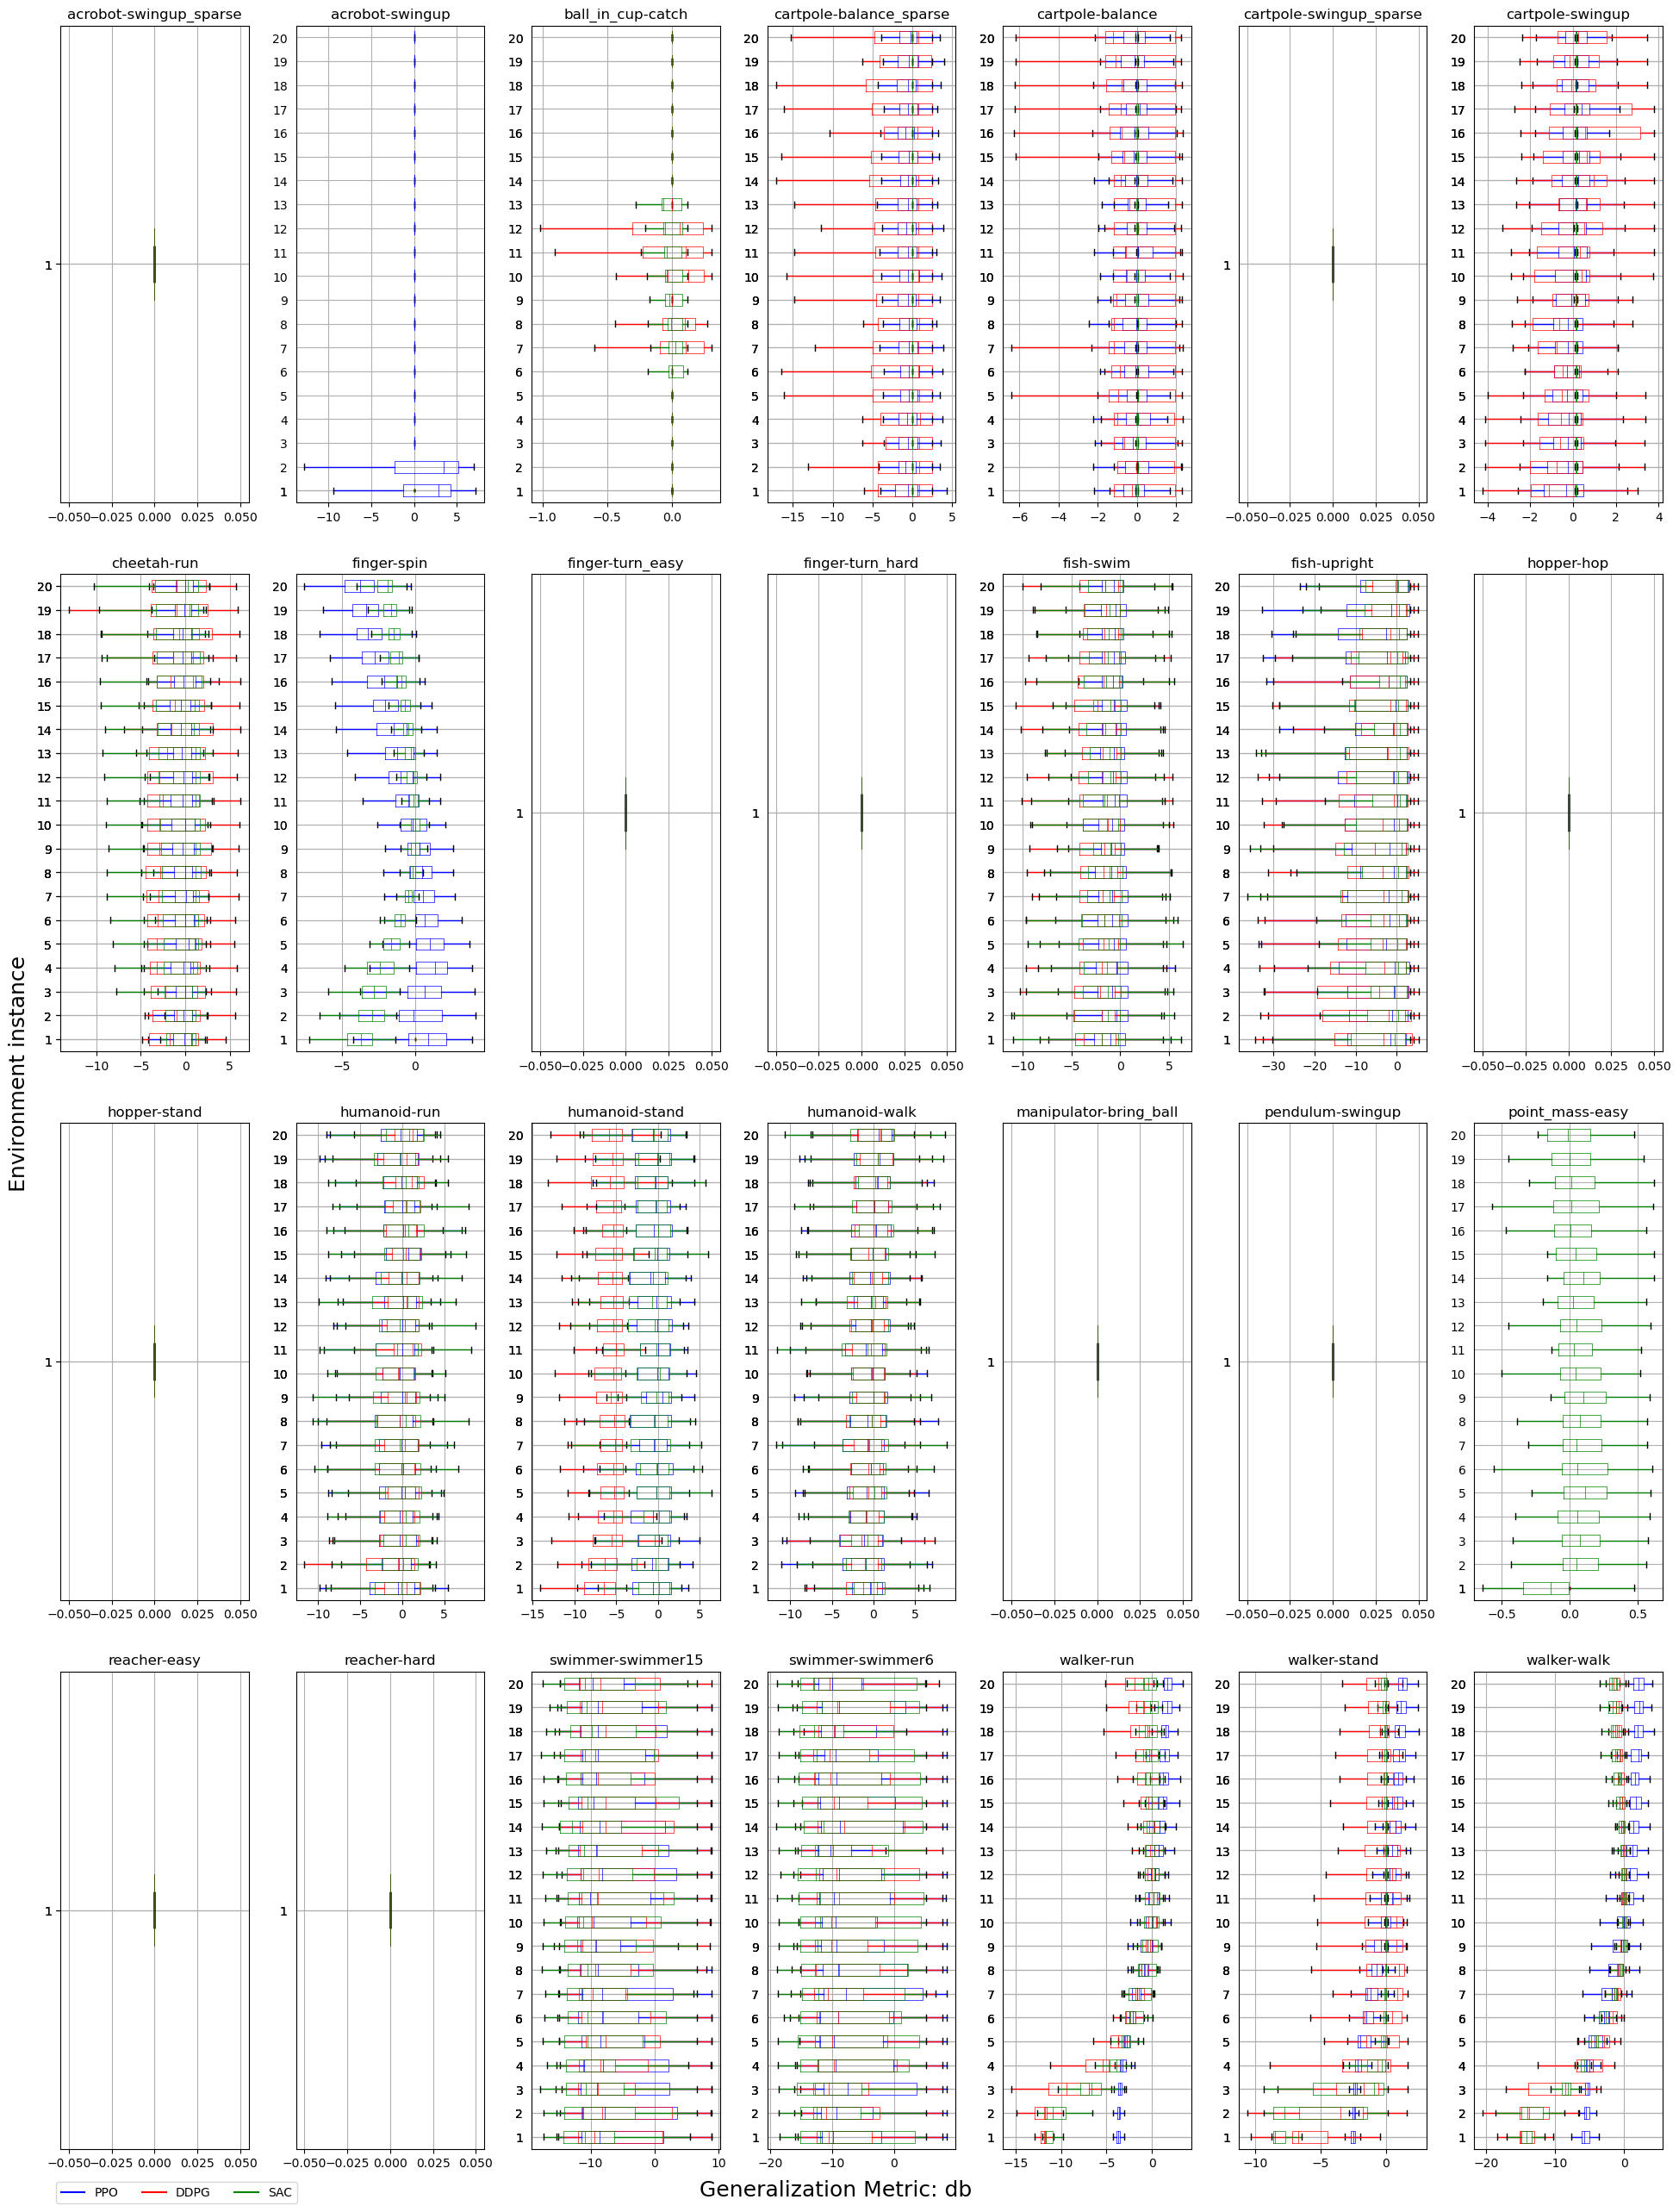

In [23]:
from typing import Callable

FIG_ROWS = 4
FIG_COLS = 7
FIG_SIZE = (24, 32)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

for gen_gap_name, gen_gap_fn in GEN_GAP_SCALARS.items():
    fig_name = f"gen_gap_{gen_gap_name}_agregated"

    fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=FIG_SIZE)

    for row in range(FIG_ROWS):
        for col in range(FIG_COLS):
            idx = row * FIG_COLS + col
            if idx >= len(ENV_TASKS):
                continue
            env_task = ENV_TASKS[idx]
            ax = axes[row][col]

            for algo, color in ALGOS.items():
                train_reward = baseline_reward(EVAL_DATA, algo, env_task)
                data = [
                    gen_gap_fn(train_reward, x)
                    for x in EVAL_DATA[algo][env_task].values()
                ]
                max_val = plot_data(ax, data, color, vertical=False)

            # format_x_axis(ax)
            ax.set_title(env_task)
            ax.grid(True)

            # Turn off x-axis labels for all rows except the last one
            if col > 0:
                # ax.set_yticks([])  # Clear existing ticks
                ax.tick_params(left=False)  # Show ticks on the left side
                # ax.tick_params(left=False)

    # Add a common ylabel for all rows
    fig.text(
        0.105,
        0.5,
        "Environment instance",
        fontsize=18,
        ha="center",
        va="center",
        rotation="vertical",
        transform=fig.transFigure,
        # letter_spacing=1.5,
    )

    # Add a common xlabel for all collumns
    fig.text(
        0.5,
        0.095,
        f"Generalization Metric: {gen_gap_name}",
        fontsize=18,
        ha="center",
        va="center",
        # rotation="vertical",
        transform=fig.transFigure,
        # letter_spacing=1.5,
    )

    # Increase the horizontal and vertical spacing between subplots
    plt.subplots_adjust(wspace=0.25, hspace=0.15)

    # Add a legend below the subplots
    handles = [
        plt.Line2D([], [], color=color, marker="", linestyle="-")
        for color in ALGOS.values()
    ]
    fig.legend(
        handles=handles,
        labels=ALGOS.keys(),
        loc="lower left",
        ncol=len(ALGOS.keys()),
        bbox_to_anchor=(0.12, 0.088),
    )

    result_file = OUTPUT_DIR.joinpath(f"{fig_name}.pdf")
    fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

    # Show the figure
    plt.show()

#### Generate data for table

In [ ]:
from tabulate import tabulate

In [25]:
FIG_ROWS = 4
FIG_COLS = 7
FIG_SIZE = (24, 32)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

for gen_gap_name, gen_gap_fn in GEN_GAP_SCALARS.items():
    section_name = f"gen_gap_{gen_gap_name}_agregated"

    for row in range(FIG_ROWS):
        for col in range(FIG_COLS):
            idx = row * FIG_COLS + col
            env_task = ENV_TASKS[idx]
            ax = axes[row][col]

            for algo, color in ALGOS.items():
                train_reward = baseline_reward(EVAL_DATA, algo, env_task)
                data = [
                    gen_gap_fn(train_reward, x)
                    for x in EVAL_DATA[algo][env_task].values()
                ]
                max_val = plot_data(ax, data, color)

            # format_x_axis(ax)
            ax.set_title(env_task)
            ax.grid(True)

            # Turn off x-axis labels for all rows except the last one
            if col > 0:
                # ax.set_yticks([])  # Clear existing ticks
                ax.tick_params(left=False)  # Show ticks on the left side
                # ax.tick_params(left=False)

    # Add a common ylabel for all rows
    fig.text(
        0.105,
        0.5,
        "Environment instance",
        fontsize=18,
        ha="center",
        va="center",
        rotation="vertical",
        transform=fig.transFigure,
        # letter_spacing=1.5,
    )

    # Add a common xlabel for all collumns
    fig.text(
        0.5,
        0.095,
        f"Generalization Metric: {gen_gap_name}",
        fontsize=18,
        ha="center",
        va="center",
        # rotation="vertical",
        transform=fig.transFigure,
        # letter_spacing=1.5,
    )

    # Increase the horizontal and vertical spacing between subplots
    plt.subplots_adjust(wspace=0.25, hspace=0.15)

    # Add a legend below the subplots
    handles = [
        plt.Line2D([], [], color=color, marker="", linestyle="-")
        for color in ALGOS.values()
    ]
    fig.legend(
        handles=handles,
        labels=ALGOS.keys(),
        loc="lower left",
        ncol=len(ALGOS.keys()),
        bbox_to_anchor=(0.12, 0.088),
    )

    result_file = OUTPUT_DIR.joinpath(f"{fig_name}.pdf")
    fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

    # Show the figure
    # plt.show()

<Figure size 640x480 with 0 Axes>

## Generate plot with reward metrics for selected tasks

In [ ]:
from typing import Callable

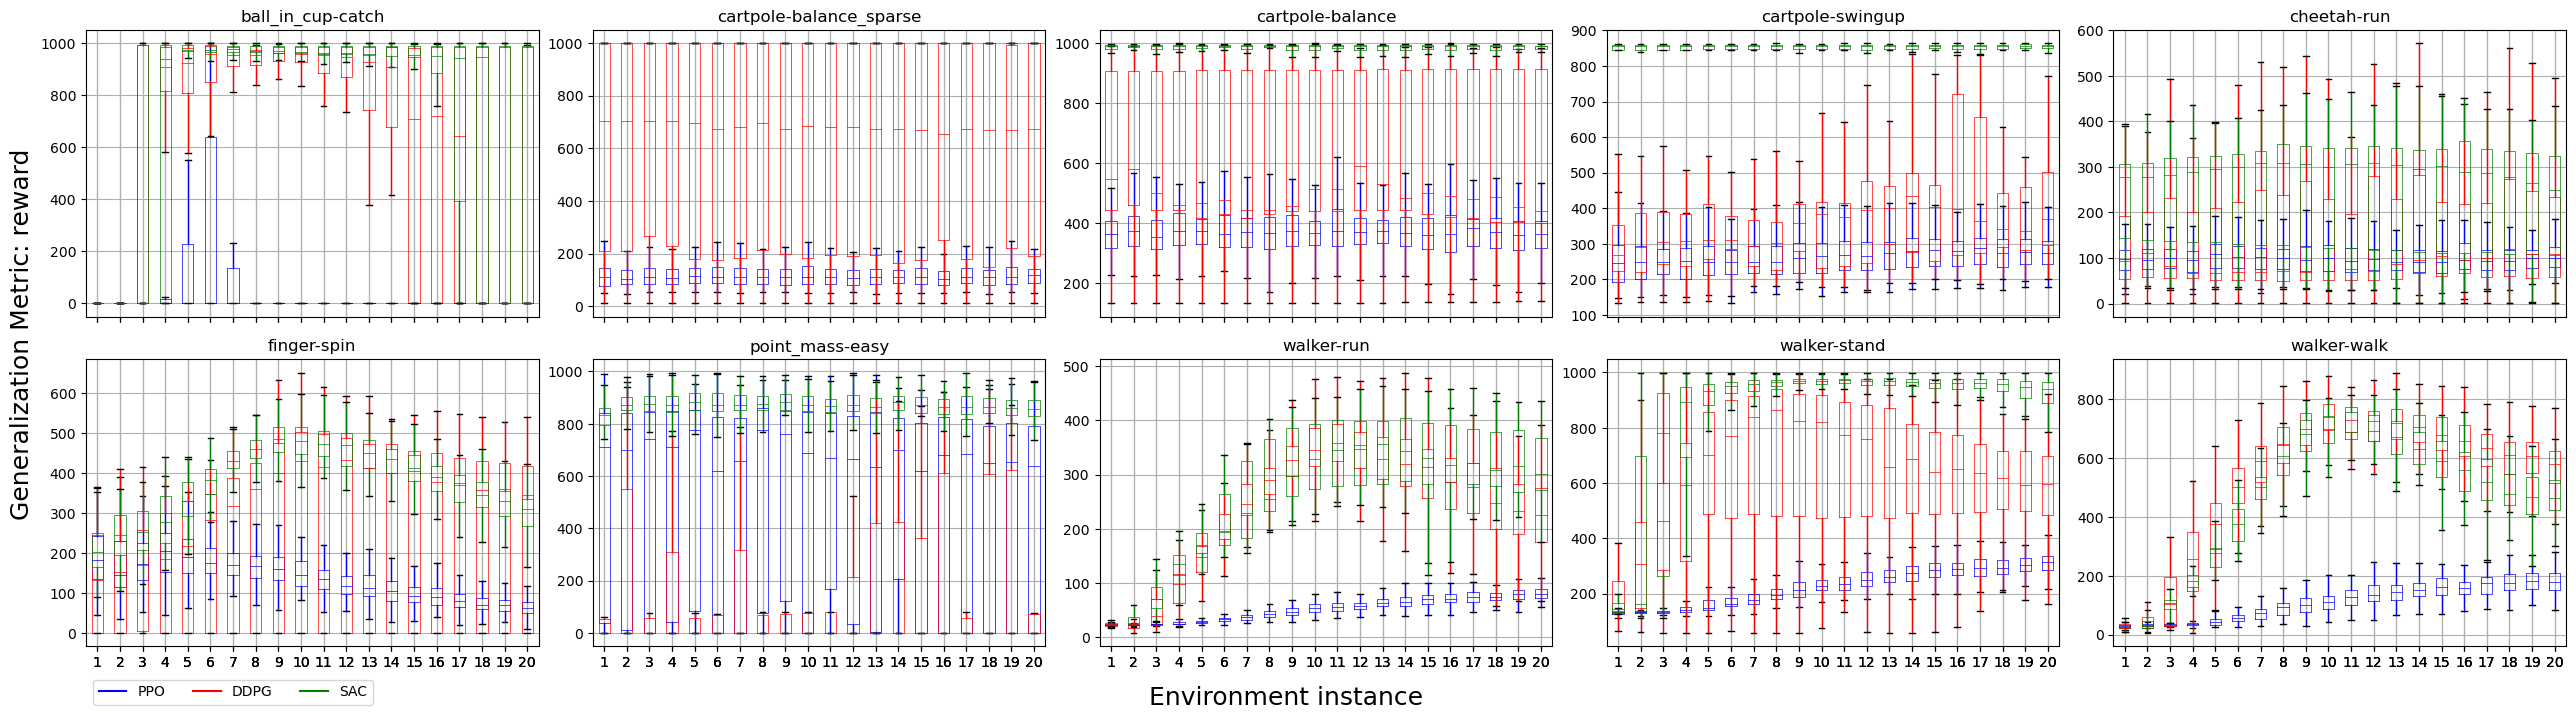

In [26]:
## GENERATE REWARD METRIC CHART

FIG_ROWS = 2
FIG_COLS = 5
FIG_SIZE = (32, 8)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

gen_gap_name = "reward"
gen_gap_fn = GEN_GAP_SCALARS[gen_gap_name]

fig_name = f"gen_gap_{gen_gap_name}"

fig, axes = plt.subplots(nrows=FIG_ROWS, ncols=FIG_COLS, figsize=FIG_SIZE)

for row in range(FIG_ROWS):
    for col in range(FIG_COLS):
        idx = row * FIG_COLS + col
        if idx >= len(ENV_TASKS_SELECTED):
            continue
        env_task = ENV_TASKS_SELECTED[idx]
        ax = axes[row][col]

        for algo, color in ALGOS.items():
            train_reward = baseline_reward(EVAL_DATA, algo, env_task)
            data = [
                gen_gap_fn(train_reward, x) for x in EVAL_DATA[algo][env_task].values()
            ]
            max_val = plot_data(ax, data, color)

        # format_x_axis(ax)
        ax.set_title(env_task)
        ax.grid(True)

        # Turn off x-axis labels for all rows except the last one
        if row + 1 < FIG_ROWS:
            ax.tick_params(labelbottom=False)
            # ax.set_yticks([])  # Clear existing ticks
            # ax.tick_params(left=False)  # Show ticks on the left side
            # ax.tick_params(left=False)

# Add a common ylabel for all rows
fig.text(
    0.105,
    0.5,
    f"Generalization Metric: {gen_gap_name}",
    fontsize=18,
    ha="center",
    va="center",
    rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Add a common xlabel for all collumns
fig.text(
    0.5,
    0.045,
    "Environment instance",
    fontsize=18,
    ha="center",
    va="center",
    # rotation="vertical",
    transform=fig.transFigure,
    # letter_spacing=1.5,
)

# Increase the horizontal and vertical spacing between subplots
plt.subplots_adjust(wspace=0.12, hspace=0.15)

# Add a legend below the subplots
handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]
fig.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="lower left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0.125, 0.028),
)

result_file = OUTPUT_DIR.joinpath(f"{fig_name}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

### Generate plot in std_dev convention

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
(0.5, 20.5)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  1  2  3  4
  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20  1  2  3  4  5  6  7  8
  9 10 11 12 13 14 15 16 17 18 19 20]
1/4 std_Dev: 5.0
100.0
20.0


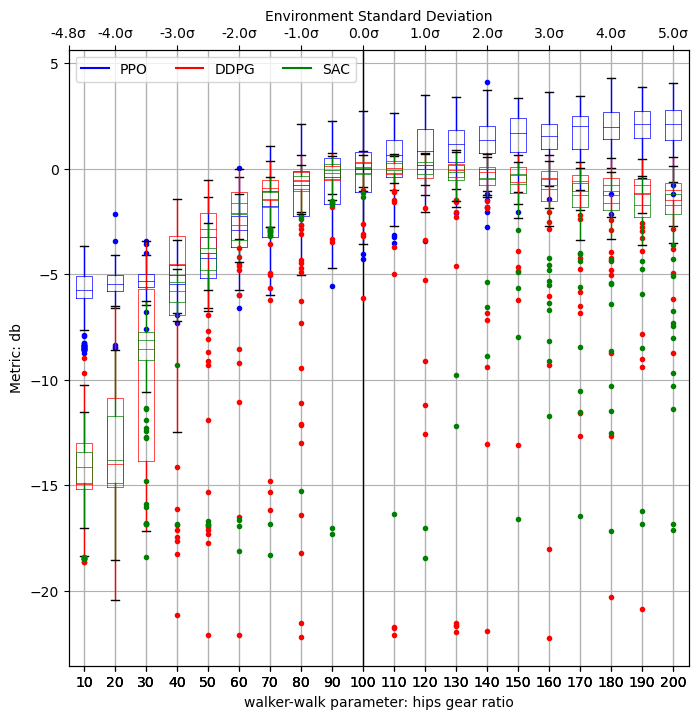

In [27]:
## GENERATE REWARD METRIC CHART

FIG_ROWS = 2
FIG_COLS = 5
FIG_SIZE = (8, 8)
ALGOS = {"PPO": "blue", "DDPG": "red", "SAC": "green"}

gen_gap_name = "db"
gen_gap_fn = GEN_GAP_SCALARS[gen_gap_name]

fig_name = f"std_dev_presentation"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=FIG_SIZE)

env_task = "walker-walk"

# Create a vertical line and set its linewidth to make it bold
ax.axvline(x=10, color="black", linewidth=1.0)

for algo, color in ALGOS.items():
    train_reward = baseline_reward(EVAL_DATA, algo, env_task)
    data_x = [gen_gap_fn(train_reward, x) for x in EVAL_DATA[algo][env_task].values()]
    max_val = plot_data(ax, data_x, color, outliers=True)

# format_x_axis(ax)
# ax.set_title(env_task)

ax.set_ylabel(f"Metric: {gen_gap_name}")
ax.set_xlabel(f"{env_task} parameter: hips gear ratio")


custom_x_labels = [0 for _ in range(0, 40)]  # FILLER, IDK WHY IT IS NEEDED

for x in range(10, 201, 10):
    custom_x_labels.append(x)  # ACTUALL DATA TO PLOT
print(custom_x_labels)
ax.set_xticklabels(custom_x_labels)


# AXIS FOR STD_DEV VALUE
std_dev_data = [x for x in range(0, 201, 10)]
mean = np.mean(std_dev_data)
# std_dev = np.std(std_dev_data)
std_dev = (200 - 0) / (5 * 2)
offset = mean

# Create the secondary axis
ax2 = ax.twiny()

print(ax.get_xlim())
print(ax.get_xticks())
x2_ticks = [
    5,
    -4 * std_dev + offset,
    -3 * std_dev + offset,
    -2 * std_dev + offset,
    -1 * std_dev + offset,
    100,
    1 * std_dev + offset,
    2 * std_dev + offset,
    3 * std_dev + offset,
    4 * std_dev + offset,
    5 * std_dev + offset,
    # x for x in np.arange(5, 210, 20)
]
print(f"1/4 std_Dev: {std_dev * 0.25}")
# Set the limits and ticks for the secondary y-axis
ax2.set_xlim([5, 205])
ax2.set_xticks(x2_ticks)
# ax2.set_xticklabels([f"{tick/std_dev:.0f}σ" for tick in x2_ticks])
ax2.set_xticklabels([f"{(tick-mean)/std_dev:.1f}σ" for tick in x2_ticks])
ax2.set_xlabel("Environment Standard Deviation")

print(mean)
print(std_dev)

ax.grid(True)


handles = [
    plt.Line2D([], [], color=color, marker="", linestyle="-")
    for color in ALGOS.values()
]

ax.legend(
    handles=handles,
    labels=ALGOS.keys(),
    loc="upper left",
    ncol=len(ALGOS.keys()),
    bbox_to_anchor=(0, 1),
)

result_file = OUTPUT_DIR.joinpath(f"{fig_name}.pdf")
fig.savefig(str(result_file), format="pdf", bbox_inches="tight")

# Show the figure
plt.show()

## Table 2 - mean metrics

In [ ]:
import pandas as pd
from tabulate import tabulate
from typing import Callable, Dict, List

In [87]:
def parse_data_to_latex_table(data: List[List]) -> str:
    df = pd.DataFrame(data)
    df.columns = pd.MultiIndex.from_tuples(zip(header, subheader))

    # Format float values as strings with 2 decimal places
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: f"${x:.2f}$")

    # Generate the LaTeX table
    table = df.to_latex(index=False)
    table = table.replace("\\textbackslash ", "\\")
    table = table.replace("\\$", "$")
    return table

In [ ]:
data = [gen_gap_fn(train_reward, x) for x in EVAL_DATA[algo][env_task].values()]

In [125]:
def process_data(gen_gap_name: str, algo: str, env_task_list: List) -> Dict:
    gen_gap_fn = GEN_GAP_SCALARS[gen_gap_name]
    data = {}
    for idx, env_task in enumerate(env_task_list):
        mean, std_dev = 0.0, 0.0
        datapoints = len(EVAL_DATA[algo][env_task].values())
        for env_instance in EVAL_DATA[algo][env_task].values():
            gen_gap_data = [gen_gap_fn(train_reward, x) for x in env_instance]
            mean += np.mean(gen_gap_data) / datapoints
            std_dev += np.std(gen_gap_data) / datapoints
        data[env_task] = {"mean": mean, "std_dev": std_dev}
    return data


def prepare_result_dicts(gen_gap_name: str) -> Dict[str, Dict]:
    algos = ["DDPG", "PPO", "SAC"]
    env_task_list = ENV_TASKS_SELECTED
    data = {}
    for algo in algos:
        data[algo] = process_data(gen_gap_name, algo, env_task_list)
    return data


mean_metric_reward = prepare_result_dicts("reward")
mean_metric_diff = prepare_result_dicts("diff")
mean_metric_ratio = prepare_result_dicts("ratio")
mean_metric_db = prepare_result_dicts("db")

In [126]:
def make_data_for_latex_table(mean_metric_data: Dict) -> List:
    algos = ["DDPG", "PPO", "SAC"]
    header = ["Environment", algos[0], "", algos[1], "", algos[2], ""]
    subheader = ["", "$\mu$", "$\sigma$", "$\mu$", "$\sigma$", "$\mu$", "$\sigma$"]

    data = [None] * len(ENV_TASKS_SELECTED)
    data_idx = 0

    for idx, env_task in enumerate(ENV_TASKS_SELECTED):
        row = [None] * 7
        idx = 0

        row[idx] = env_task
        idx += 1
        for algo in algos:
            for param in ["mean", "std_dev"]:
                # print(f"idx: {idx}")
                row[idx] = mean_metric_data[algo][env_task][param]
                idx += 1
        data[data_idx] = row
        data_idx += 1

    return data

In [127]:
print(
    """
┏━┓┏━╸╻ ╻┏━┓┏━┓╺┳┓
┣┳┛┣╸ ┃╻┃┣━┫┣┳┛ ┃┃
╹┗╸┗━╸┗┻┛╹ ╹╹┗╸╺┻┛
# --------------- #
Mean Reward Metric
"""
)

data = make_data_for_latex_table(mean_metric_reward)
table = parse_data_to_latex_table(data)
print(table)

# ------------ #

print(
    """
╺┳┓╻┏━╸┏━╸
 ┃┃┃┣╸ ┣╸ 
╺┻┛╹╹  ╹  
# --------------- #
Mean Diff Metric
"""
)

data = make_data_for_latex_table(mean_metric_diff)
table = parse_data_to_latex_table(data)
print(table)

# ------------ #

print(
    """
┏━┓┏━┓╺┳╸╻┏━┓
┣┳┛┣━┫ ┃ ┃┃ ┃
╹┗╸╹ ╹ ╹ ╹┗━┛
# --------------- #
Mean Ratio Metric
"""
)

data = make_data_for_latex_table(mean_metric_ratio)
table = parse_data_to_latex_table(data)
print(table)

# ------------ #

print(
    """
╺┳┓┏━╸┏━╸╻┏┓ ┏━╸╻  
 ┃┃┣╸ ┃  ┃┣┻┓┣╸ ┃  
╺┻┛┗━╸┗━╸╹┗━┛┗━╸┗━╸
# --------------- #
Mean Decibel Metric
"""
)

data = make_data_for_latex_table(mean_metric_db)
table = parse_data_to_latex_table(data)
print(table)

# ------------ #


┏━┓┏━╸╻ ╻┏━┓┏━┓╺┳┓
┣┳┛┣╸ ┃╻┃┣━┫┣┳┛ ┃┃
╹┗╸┗━╸┗┻┛╹ ╹╹┗╸╺┻┛
# --------------- #
Mean Reward Metric

\begin{tabular}{lllllll}
\toprule
            Environment & \multicolumn{2}{l}{DDPG} & \multicolumn{2}{l}{PPO} & \multicolumn{2}{l}{SAC} \\
                        &    $\mu$ & $\sigma$ &    $\mu$ & $\sigma$ &     $\mu$ & $\sigma$ \\
\midrule
      ball\_in\_cup-catch & $651.32$ & $311.26$ & $140.47$ & $328.74$ &  $747.76$ & $227.71$ \\
cartpole-balance\_sparse & $573.84$ & $377.22$ & $119.27$ &  $49.27$ & $1000.00$ &   $0.00$ \\
       cartpole-balance & $576.91$ & $297.67$ & $372.62$ &  $73.57$ &  $982.44$ &  $14.81$ \\
       cartpole-swingup & $373.52$ & $156.72$ & $265.25$ &  $56.47$ &  $825.74$ &  $61.45$ \\
            cheetah-run & $142.52$ & $137.84$ &  $99.03$ &  $32.67$ &  $225.99$ & $130.36$ \\
            finger-spin & $233.20$ & $195.36$ & $137.04$ &  $41.81$ &  $375.01$ &  $48.48$ \\
        point\_mass-easy & $184.80$ & $312.61$ & $529.55$ & $357.91$ &  $859.59$ &  $67.63$ 

/tmp/ipykernel_200/3693583714.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=False)
/tmp/ipykernel_200/3693583714.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = df.to_latex(index=False)
/tmp/ipykernel_200/3693583714.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is reco